Implementación de modelos SARIMA para el análisis de los ingresos de Walmart en el estado de California, Estados Unidos. 

In [1]:
!pip install --upgrade pip
!pip install kats
!pip install ax-platform==0.2.4 statsmodels==0.12.2

# Tratamiento de Datos
import numpy as np
import pandas as pd

#Graficos
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from kats.detectors.outlier import OutlierDetector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 8.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.5/612.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.3/950.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.9/347.9 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 17.1 MB/s eta 0:0

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
#!pip install --upgrade pip
#!pip install kats
 #ax-platform==0.2.3 statsmodels==0.12.2

## Librerias

Lectura de los datos luego de los procesos de transformación y limpieza propuestos por el equipo

In [3]:
pa1 = '/content/gdrive/MyDrive/Maestría_CDA/2_SEMESTRE/Met_Estadísticos Avanzados /Proyecto Integrador/Fuentes/3.2_total_sales_mean25_Foods.csv'
#pa2 = "/content/gdrive/MyDrive/Met_Estadísticos Avanzados /Proyecto Integrador/Fuentes/3.2_total_sales_mean25_Foods.csv"
Foods= pd.read_csv(pa1)

# Análisis descriptivo de la serie

Veamos gráficamente el comportamiento de la serie original

In [ ]:
plt.figure(figsize=(40, 20))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Serie de tiempo categoría alimentos con datos originales',fontsize=32)
plt.plot(Foods['date'],Foods['total_sells'])
plt.show()

Gráficamente se puede observar comportamiento de tendencia creciente no lineal y varianza no constante. A continuación se propone la descomposición aditiva y multiplicativa de la serie e identificar las posibles transformaciones requeridas.

Adiciionalmente se identifican datos atípicos en la serie que deben ser tratados 

## **Detección de Outliers**

In [ ]:
ts = Foods.set_index("date")[["total_sells"]].reset_index()
ts.columns = ["time", "value"]

Como se mencionó previamente, la serie de tiempo presenta outliers que deben ser interpolados de manera que la predicción de la serie de tiempo disminuya el error. Para esto vamos a hacer uso de la librería kats de Python 

In [ ]:
# Se utiliza la librería kats para identificar e interpolar los outiliers
from kats.consts import TimeSeriesData
ts = TimeSeriesData(ts)
outlier_detector = OutlierDetector(ts, "additive")
outlier_detector.detector()
outliers = outlier_detector.outliers
ts_day_outliers_interpolated = outlier_detector.remover(interpolate=True)

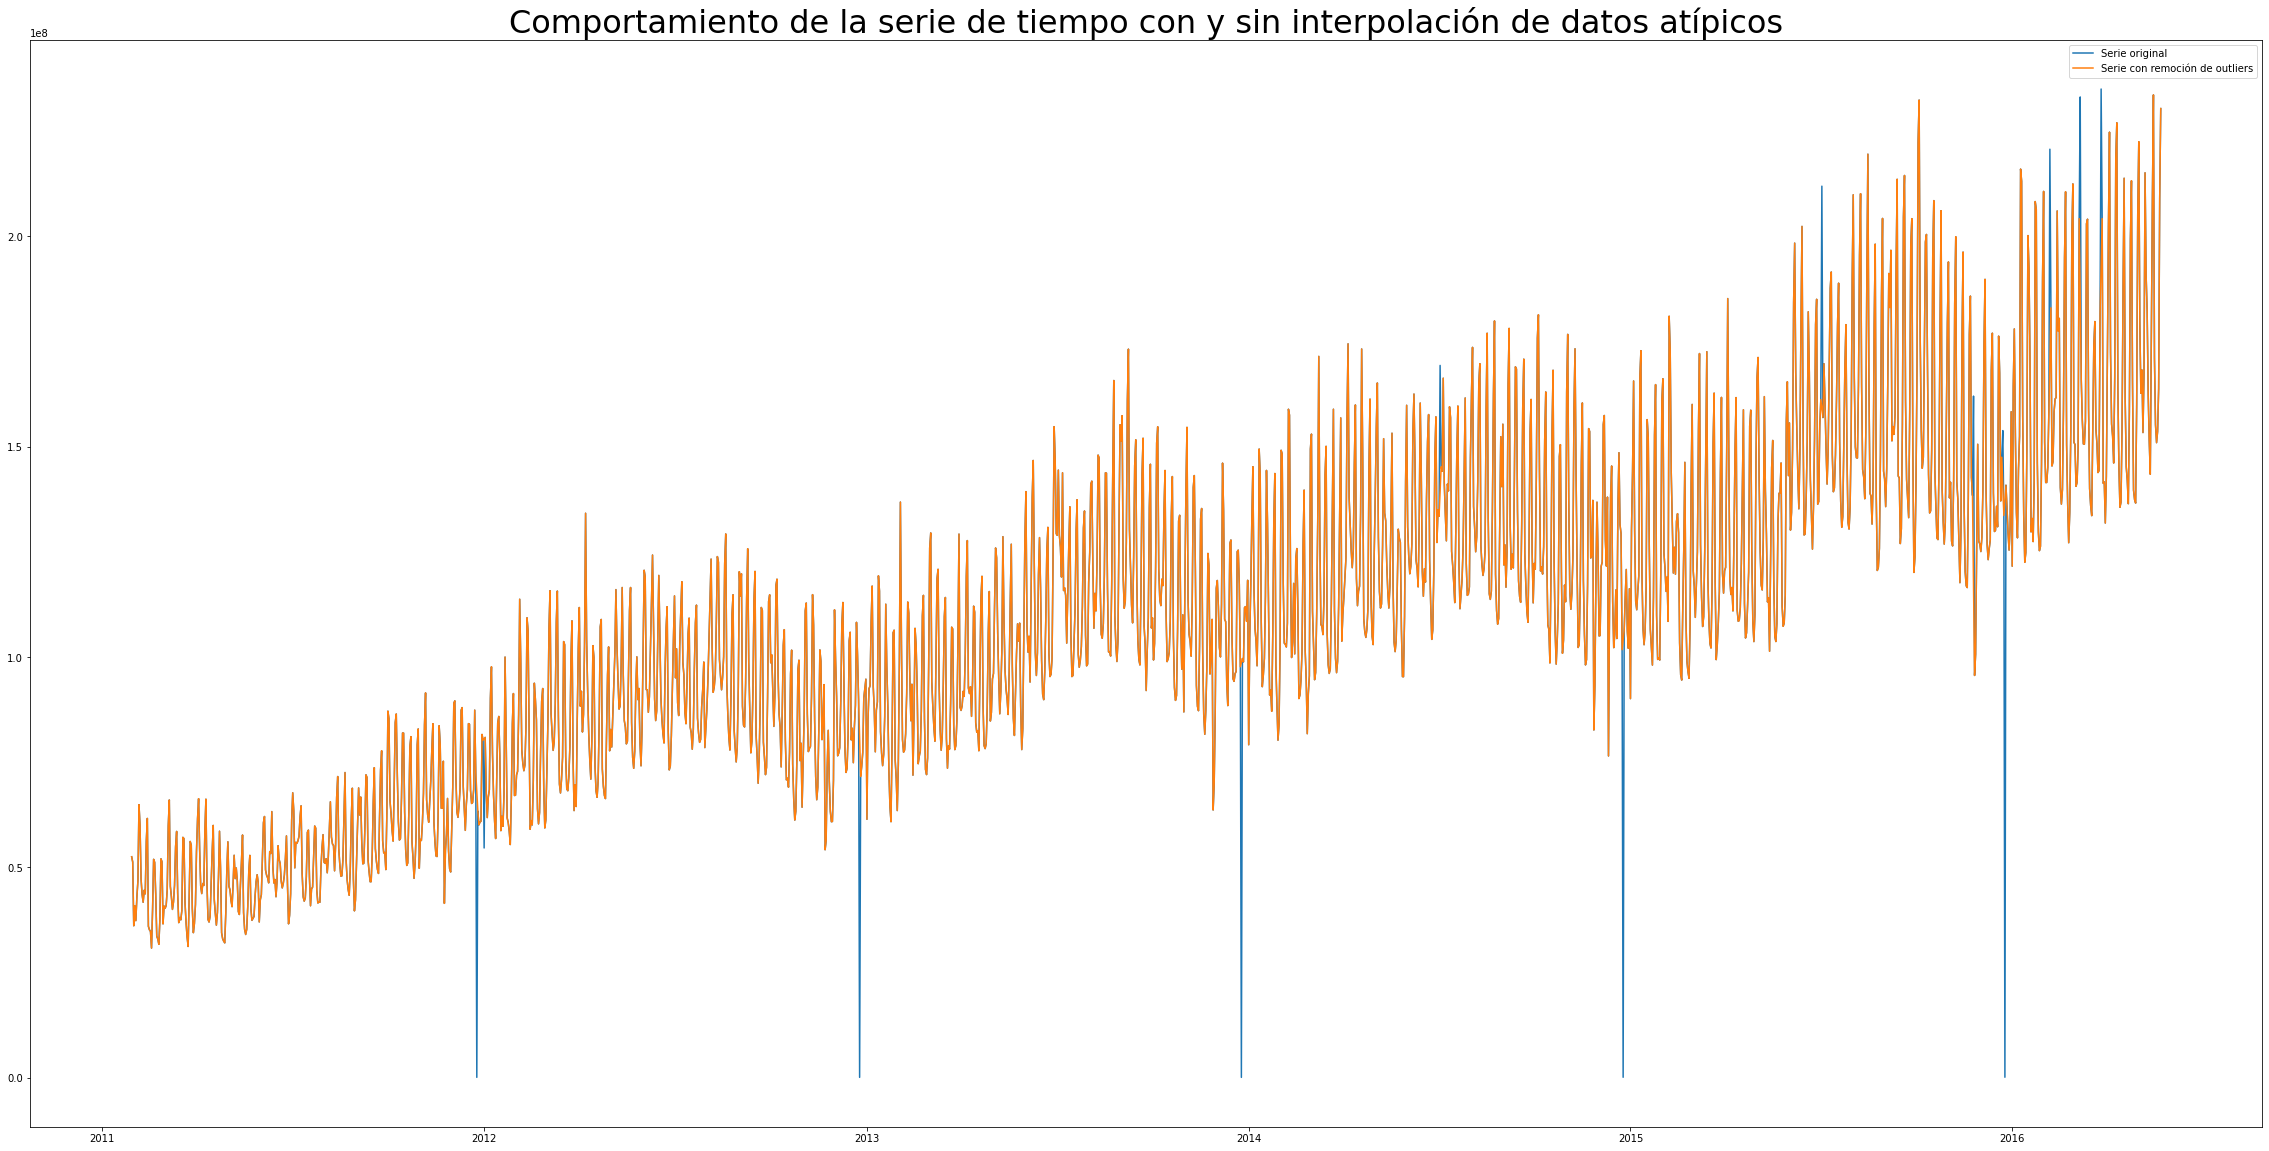

In [ ]:
plt.figure(figsize=(40, 20))
plt.plot(ts.to_dataframe().time, ts.to_dataframe().value)
plt.title('Comportamiento de la serie de tiempo con y sin interpolación de datos atípicos',fontsize=32)
plt.plot(ts_day_outliers_interpolated.to_dataframe().time, ts_day_outliers_interpolated.to_dataframe().y_0)
plt.legend(labels=["Serie original", "Serie con remoción de outliers"])

Gráficamente se puede observar que al realizar la imputación de los datos (usando el dato promedio entre sus vecinos) mantiene la misma estructura pero disminuyendo el efecto de los datos atípicos. 

In [ ]:
Foods["date"] = ts_day_outliers_interpolated.to_dataframe()["time"]
Foods["total_sells"] = ts_day_outliers_interpolated.to_dataframe()["y_0"]

# 1.1. DESCOMPOSICIÓN DE LA SERIE EN SUS COMPONENTES

Una serie de tiempo puede presentar diferentes patrones tanto en el comportamiento de la tendencia como de la estacionalidad y sus residuales con ello puede variar el modelamiento de la misma bien sea aditiva (sumatoria de sus componentes) o multiplicativa (expresada como el rpoducto de sus componentes). 

A continuación, evaluaremos los componentes de manera individual para determinar la tipología en el caso de las ventas de alimentos en las tiendas walmart de California. 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [ ]:
Foods["date"] = pd.to_datetime(Foods["date"])
Foods.set_index("date", inplace = True)
Foods = Foods.asfreq('1D')
Foods = Foods.sort_index()

Se verifica que los datos de la serie de tiempo estén completos 

In [ ]:
(Foods.index == pd.date_range(
                    start = Foods.index.min(),
                    end   = Foods.index.max(),
                    freq  = Foods.index.freq)
                ).all()

True

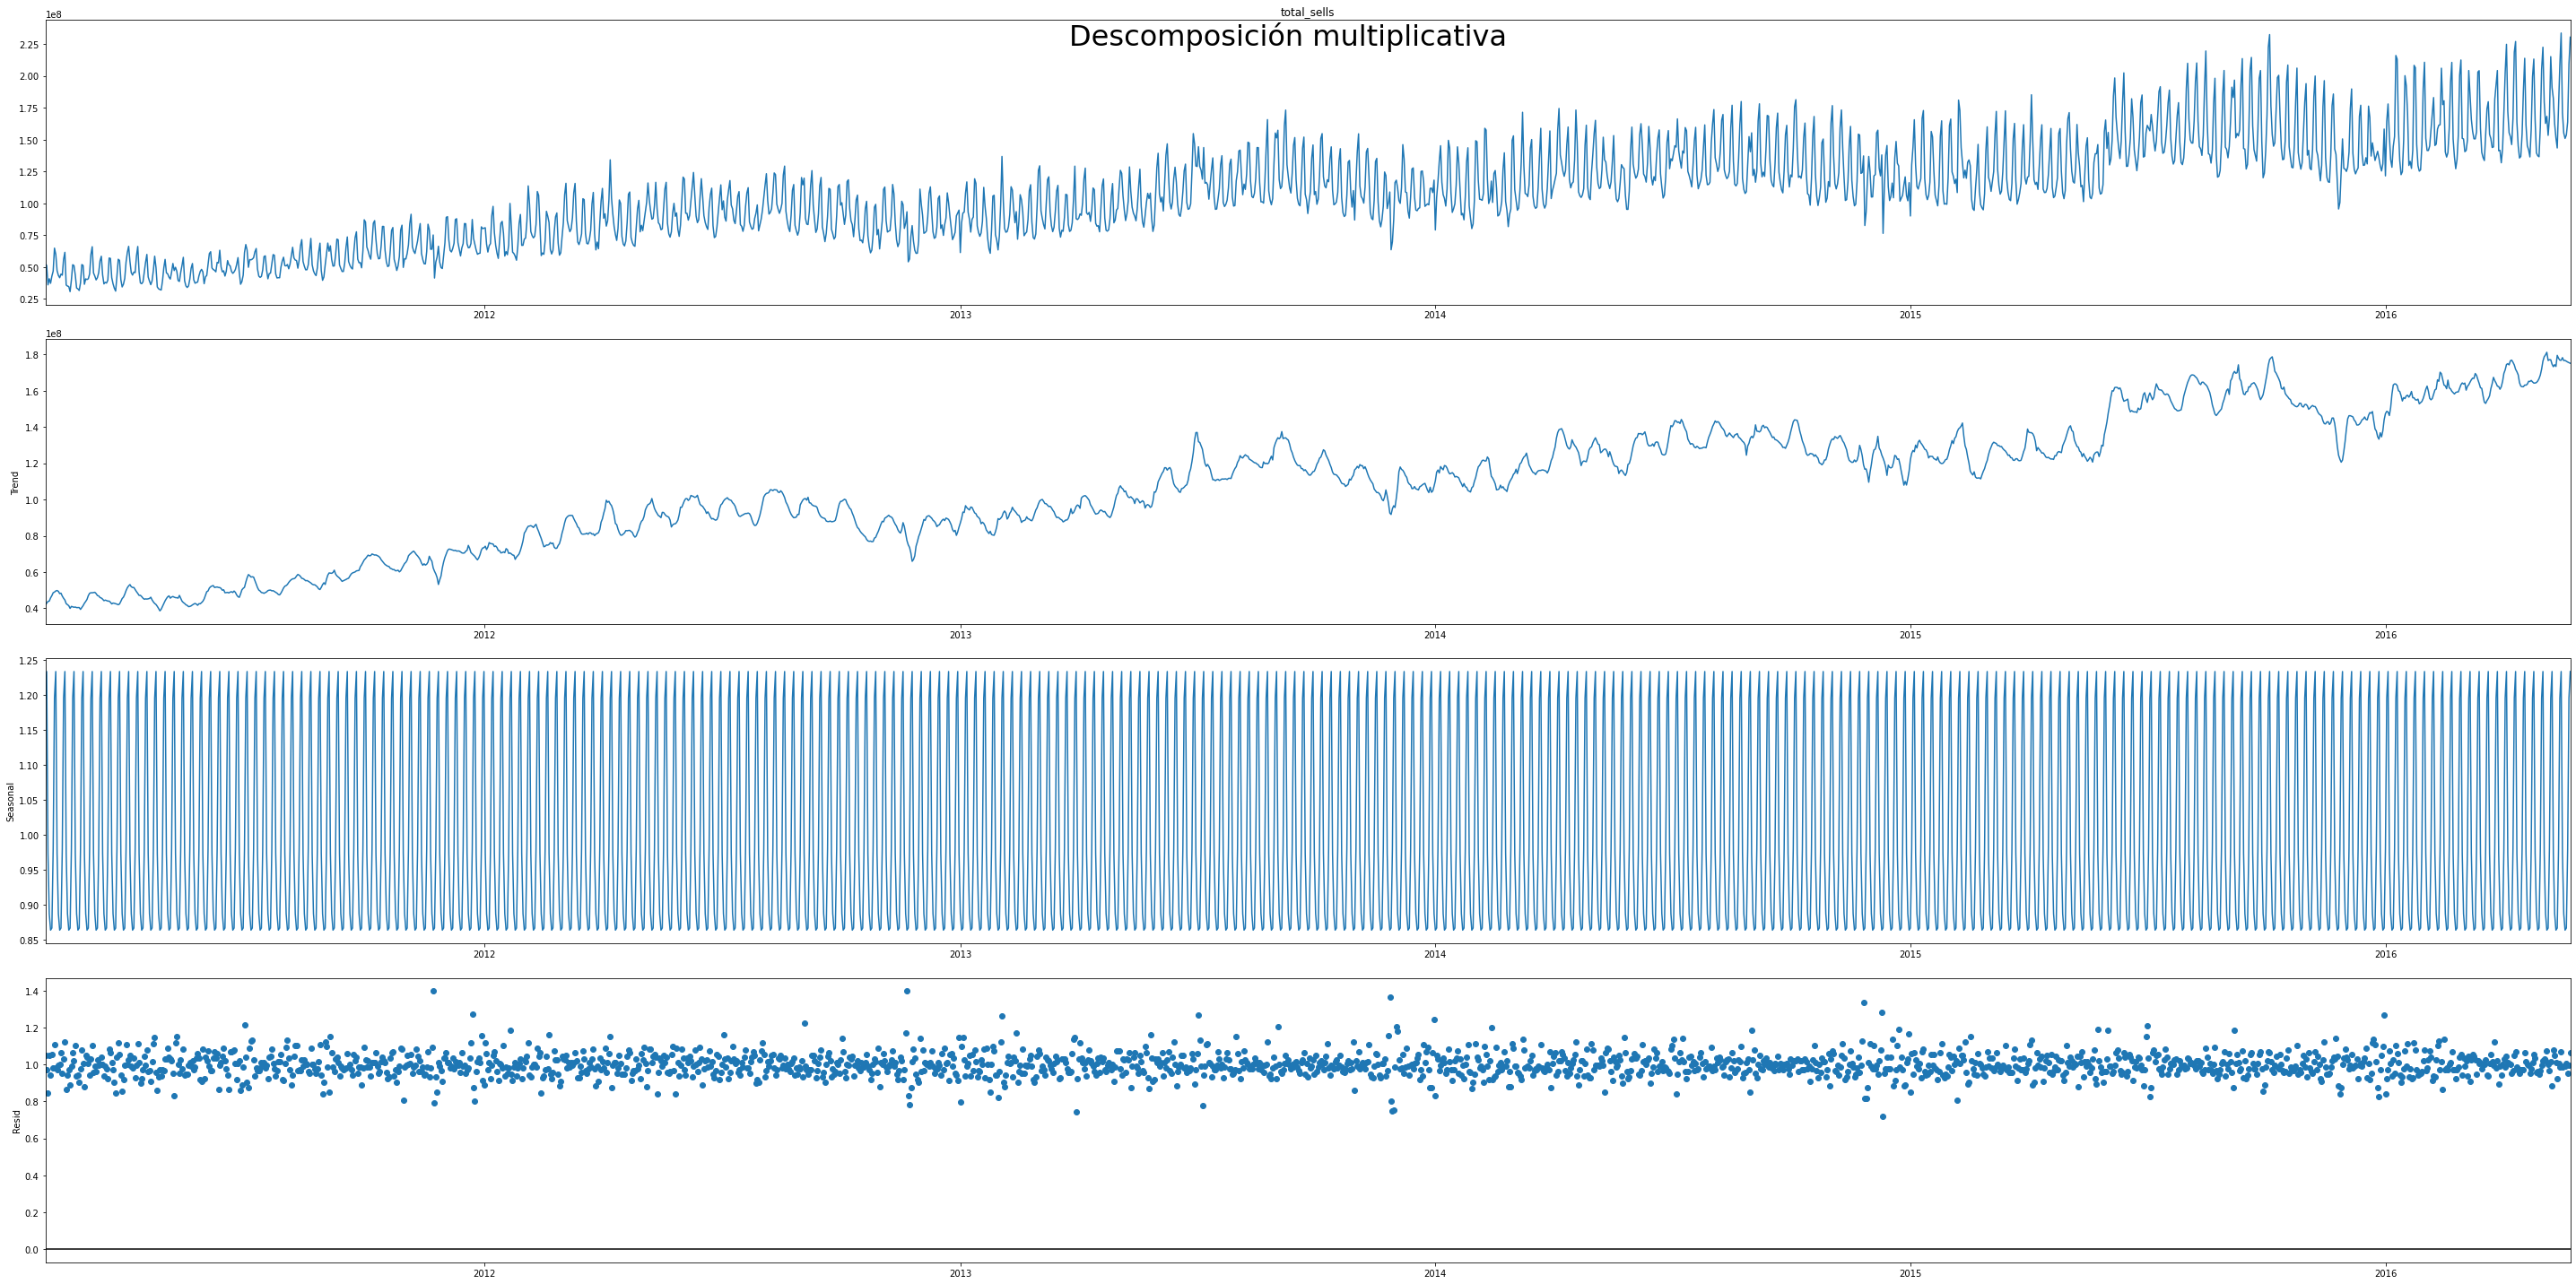

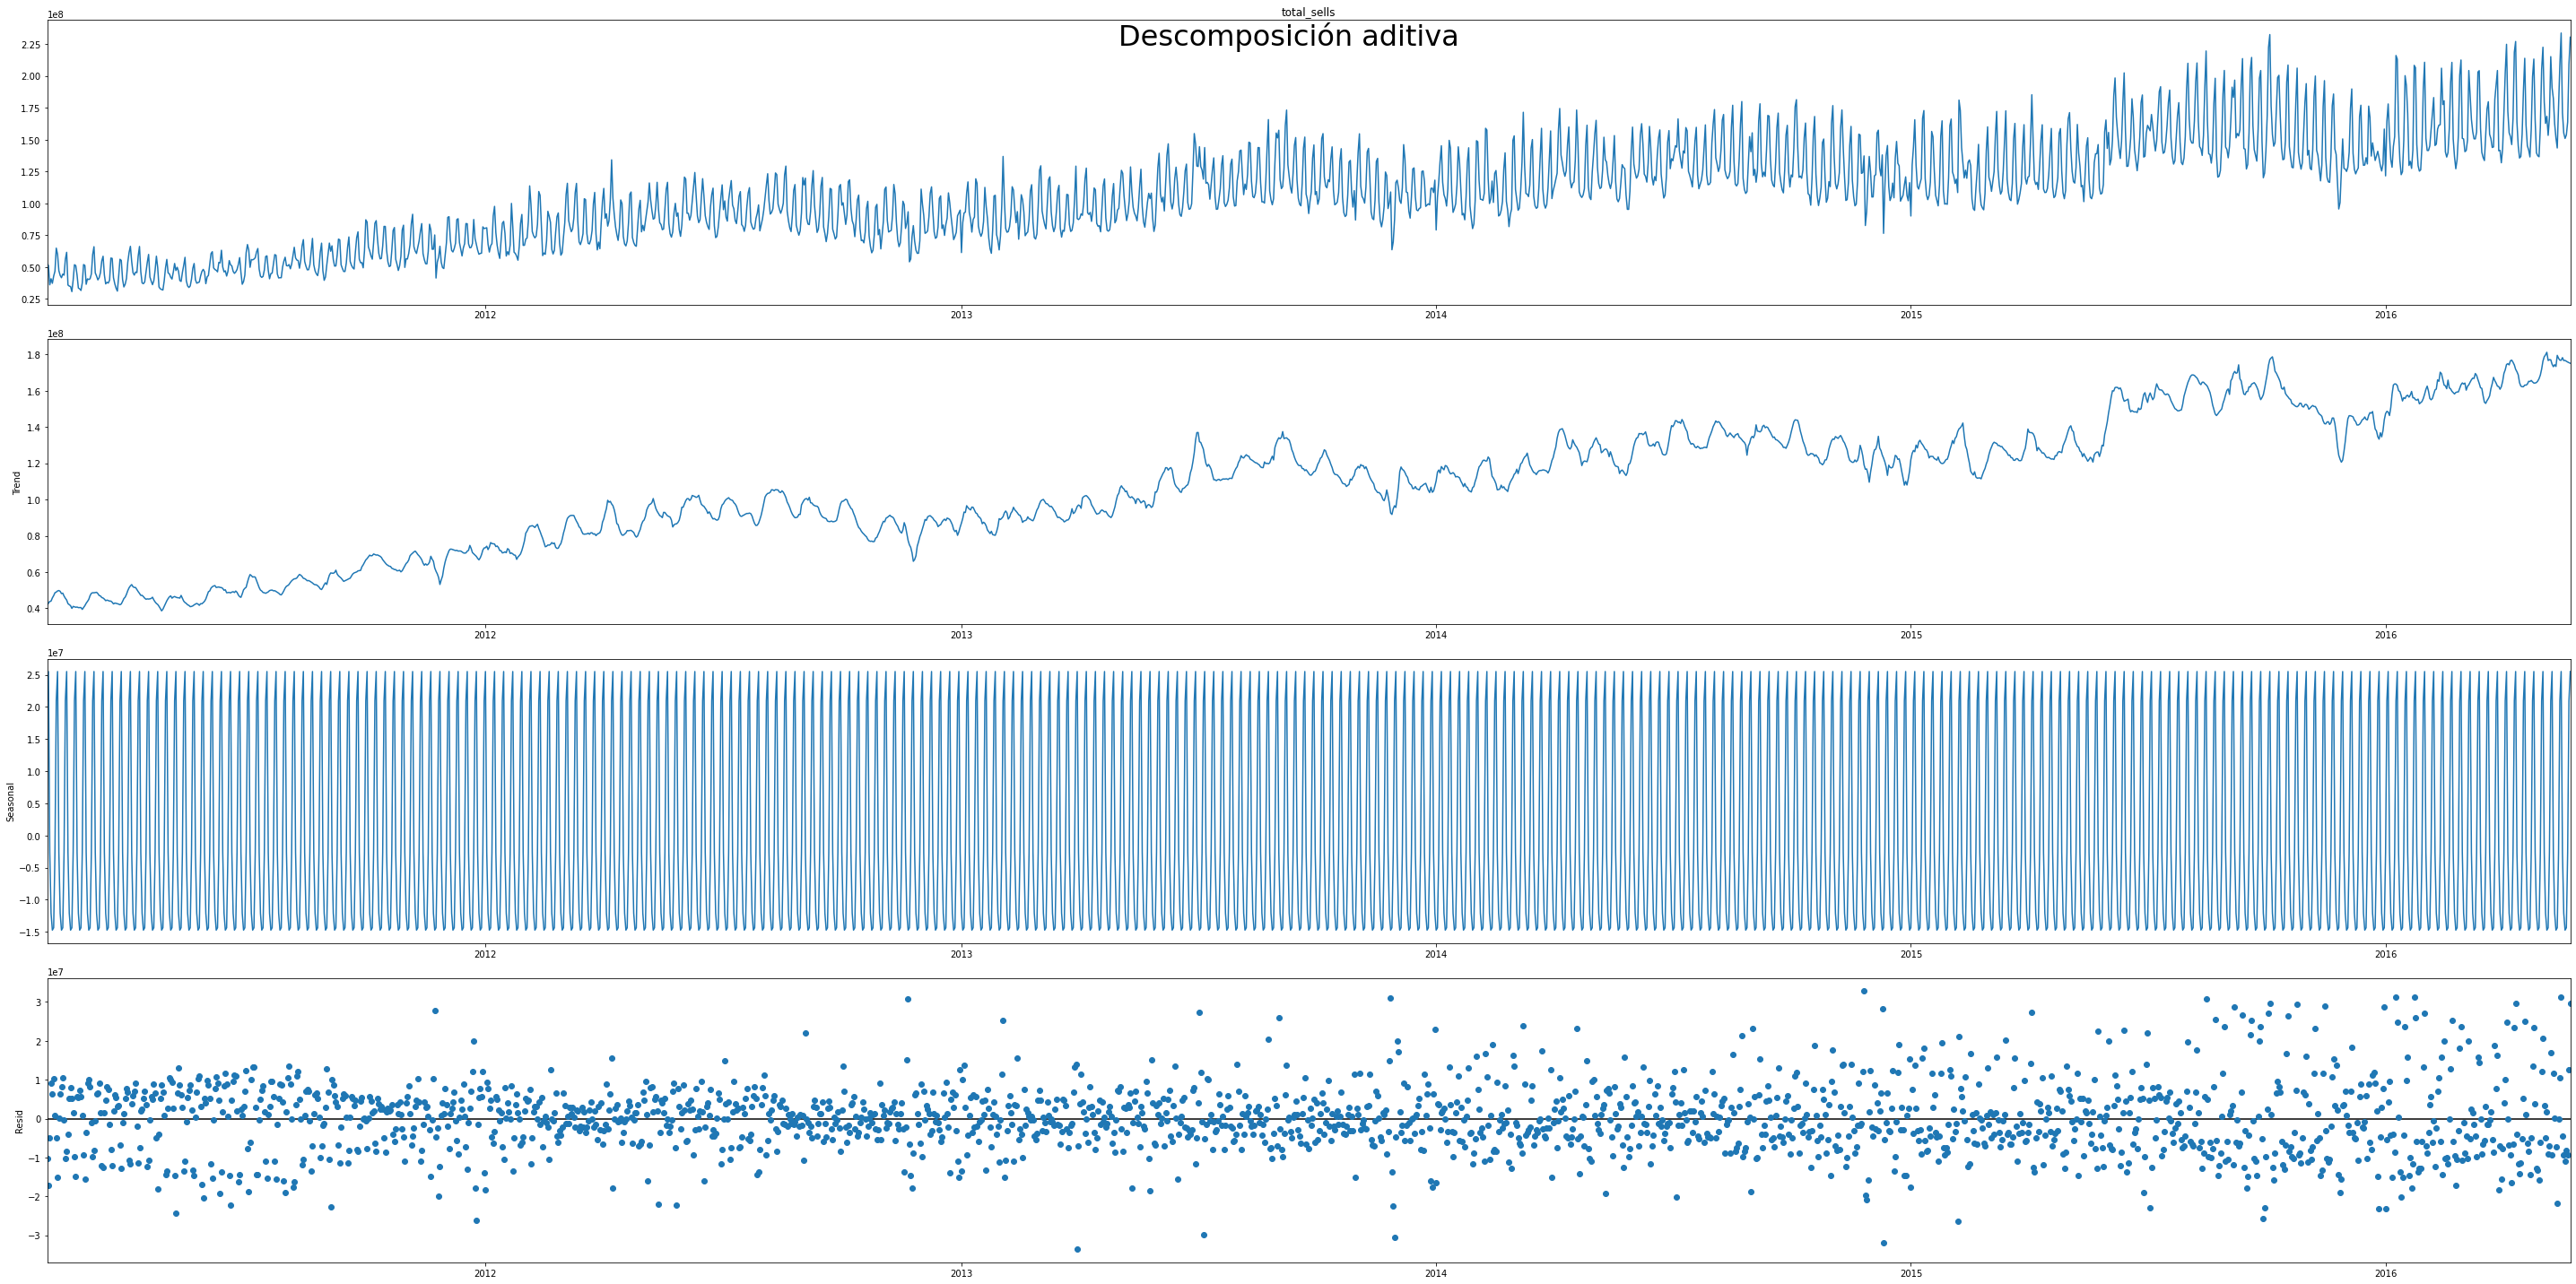

In [ ]:
# Descomposición multiplicativa
result_mul = seasonal_decompose(Foods['total_sells'], model='multiplicative', extrapolate_trend='freq')

# Descomposición aditiva
result_add = seasonal_decompose(Foods['total_sells'], model='additive', extrapolate_trend='freq')

# Gráfico de los componentes de la seie 
plt.rcParams.update({'figure.figsize': (40,20)})
result_mul.plot().suptitle('Descomposición multiplicativa', fontsize=32)
result_add.plot().suptitle('Descomposición aditiva', fontsize=32)
plt.show()

Al observar los residuos de ambas descomposiciones se puede notar una mayor aleatoriedad en los datos utilizando la descomposición multiplicativa, mientras que en el caso de la descomposición aditiva se nota una mayor dispersión y patrones no modelados. Por lo tanto, en el análisis de la categoría food se recomienda la descomposición multiplicativa. 

In [ ]:
# Partición de la serie entre sus componentes 
Food_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
Food_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
Food_reconstructed.head()

seas         trend     resid  actual_values
date                                                       
2011-01-29  1.195855  4.183795e+07  1.049440    52505705.07
2011-01-30  1.233819  4.280764e+07  0.970587    51263366.34
2011-01-31  0.973650  4.377732e+07  0.846837    36095398.08
2011-02-01  0.887050  4.396825e+07  1.048090    40877622.48
2011-02-02  0.863548  4.573658e+07  0.944703    37311746.46

Considerando el análsiis anterior, la serie de tiempo correspondiente a las ventas de productos alimenticios en las tiendas de Walmart puede ser expresada de la siguiente manera: 

\begin{equation}
Valor actual = estación * tendencia * residuales
\end{equation}

De los gráficos anteriores haciendo uso de la serie diaria no se logra ver claramente la componente estacional dada la cantidad de registro, por lo que se propone revisar el comportamiento de la serie mensual y generar la descomposición con el objetivo de validar el componente estacional. 

In [ ]:
Foods_m = Foods.resample('M').mean()
Foods_m.head()

Unnamed: 0   total_sells
date                                
2011-01-31         3.0  4.662149e+07
2011-02-28        49.5  4.393694e+07
2011-03-31       138.0  4.457244e+07
2011-04-30       229.5  4.646523e+07
2011-05-31       321.0  4.407026e+07

<Figure size 2880x1440 with 0 Axes>

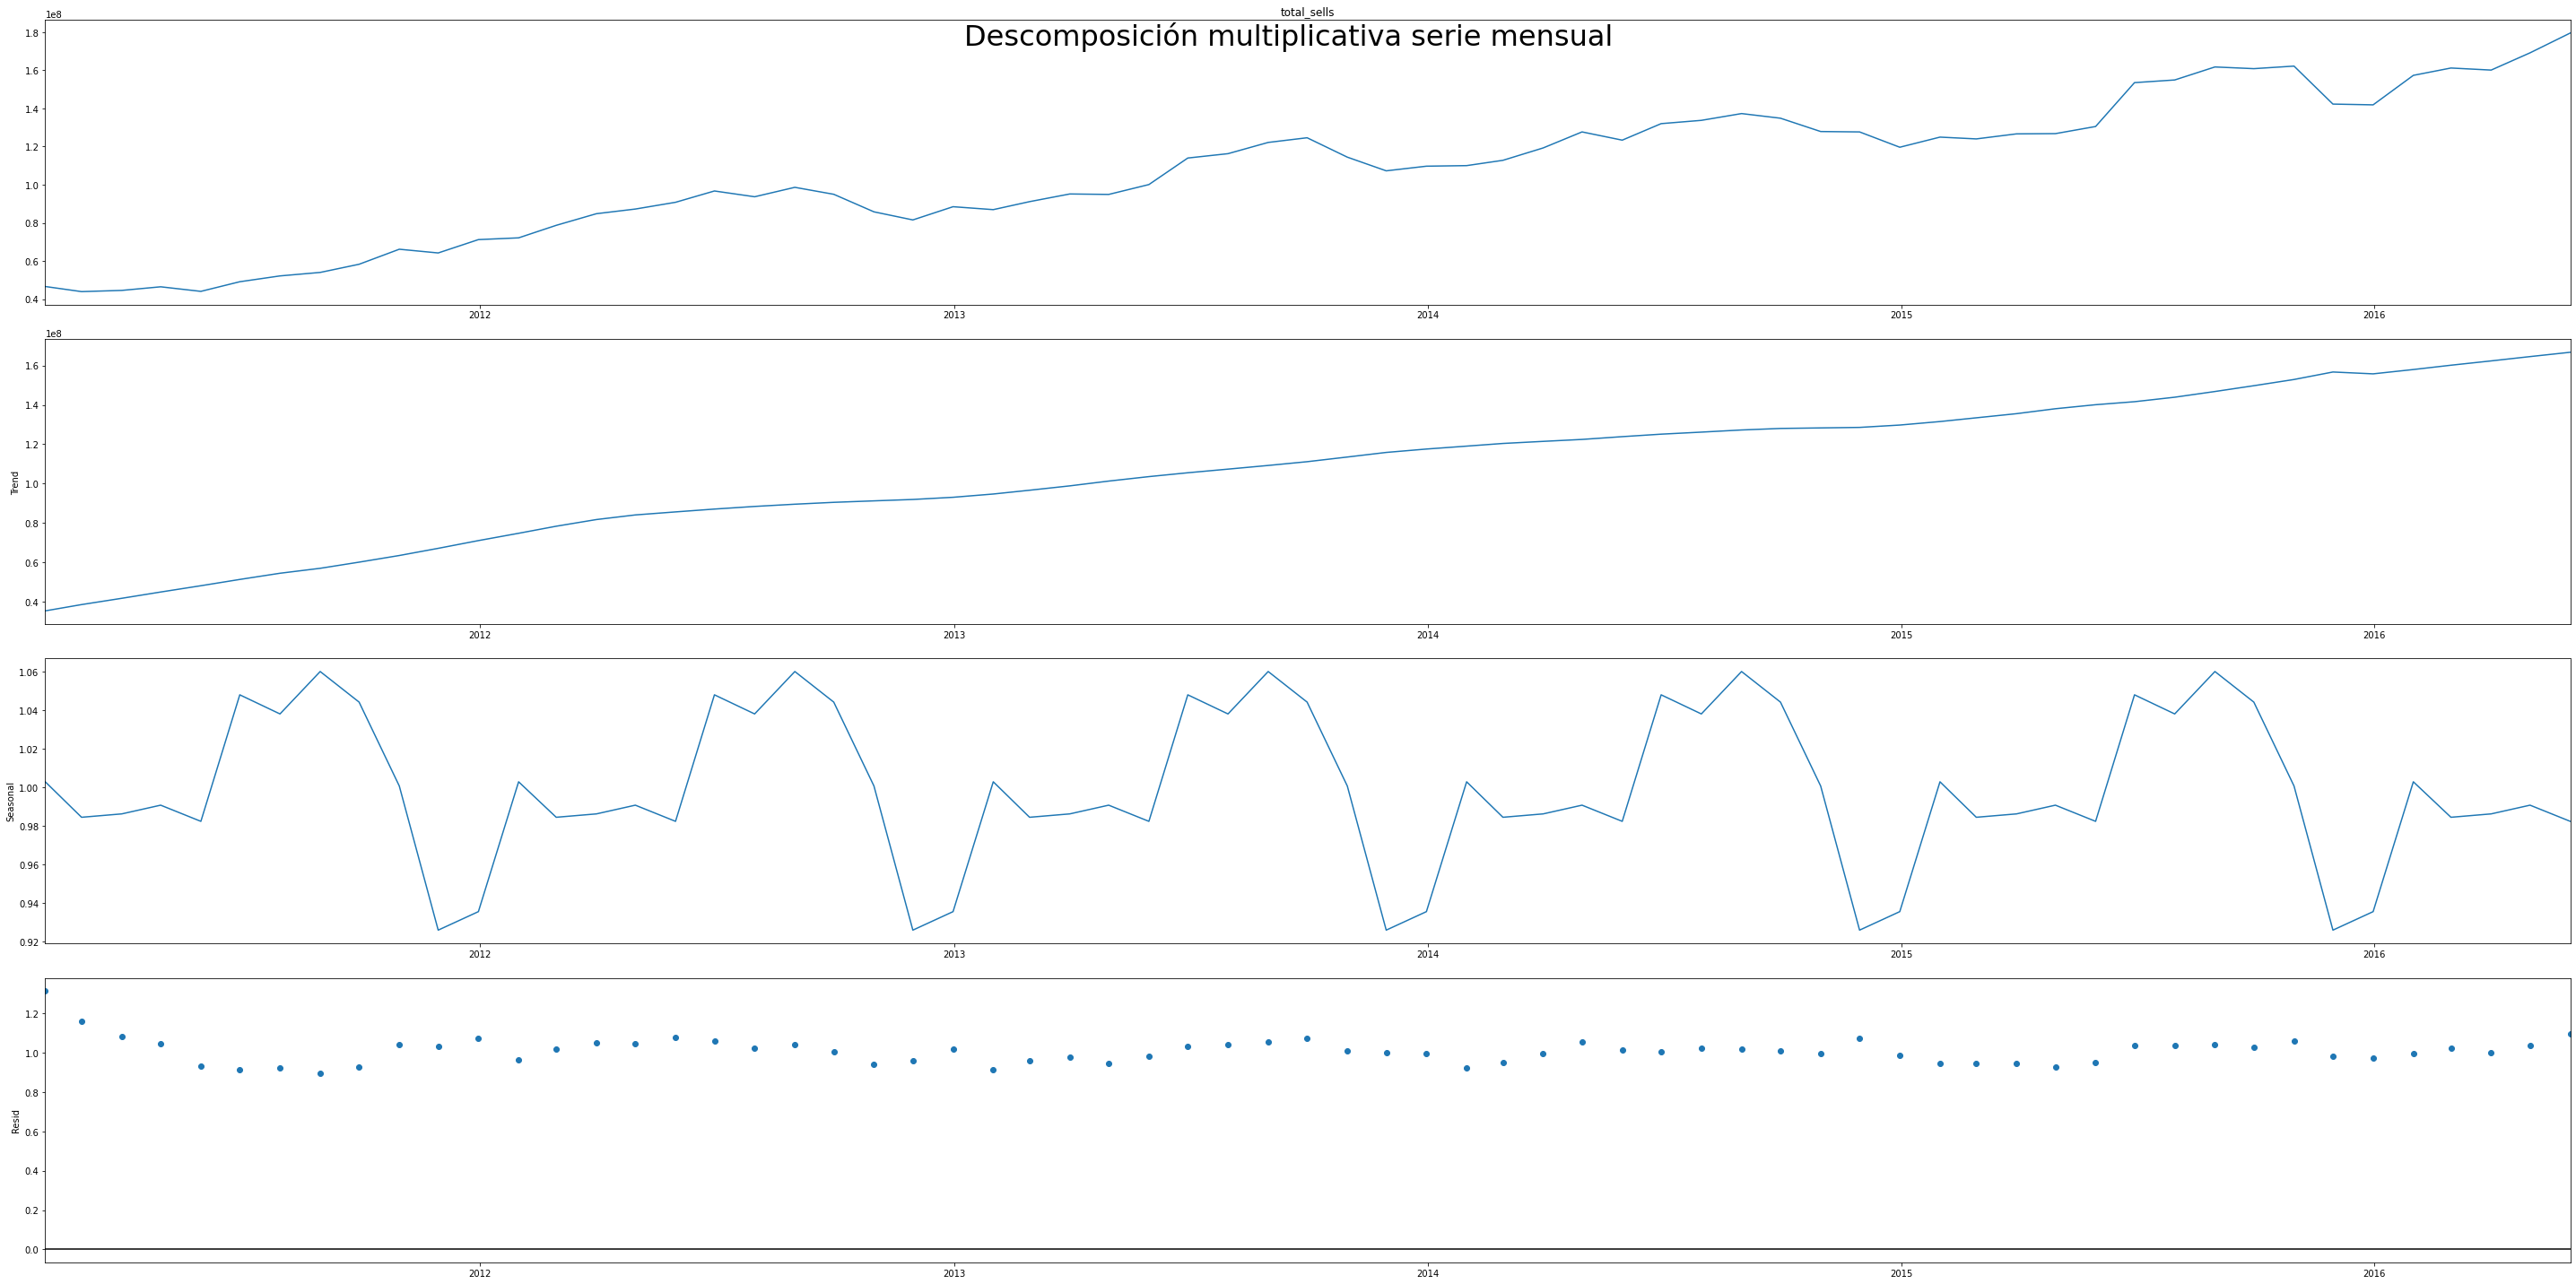

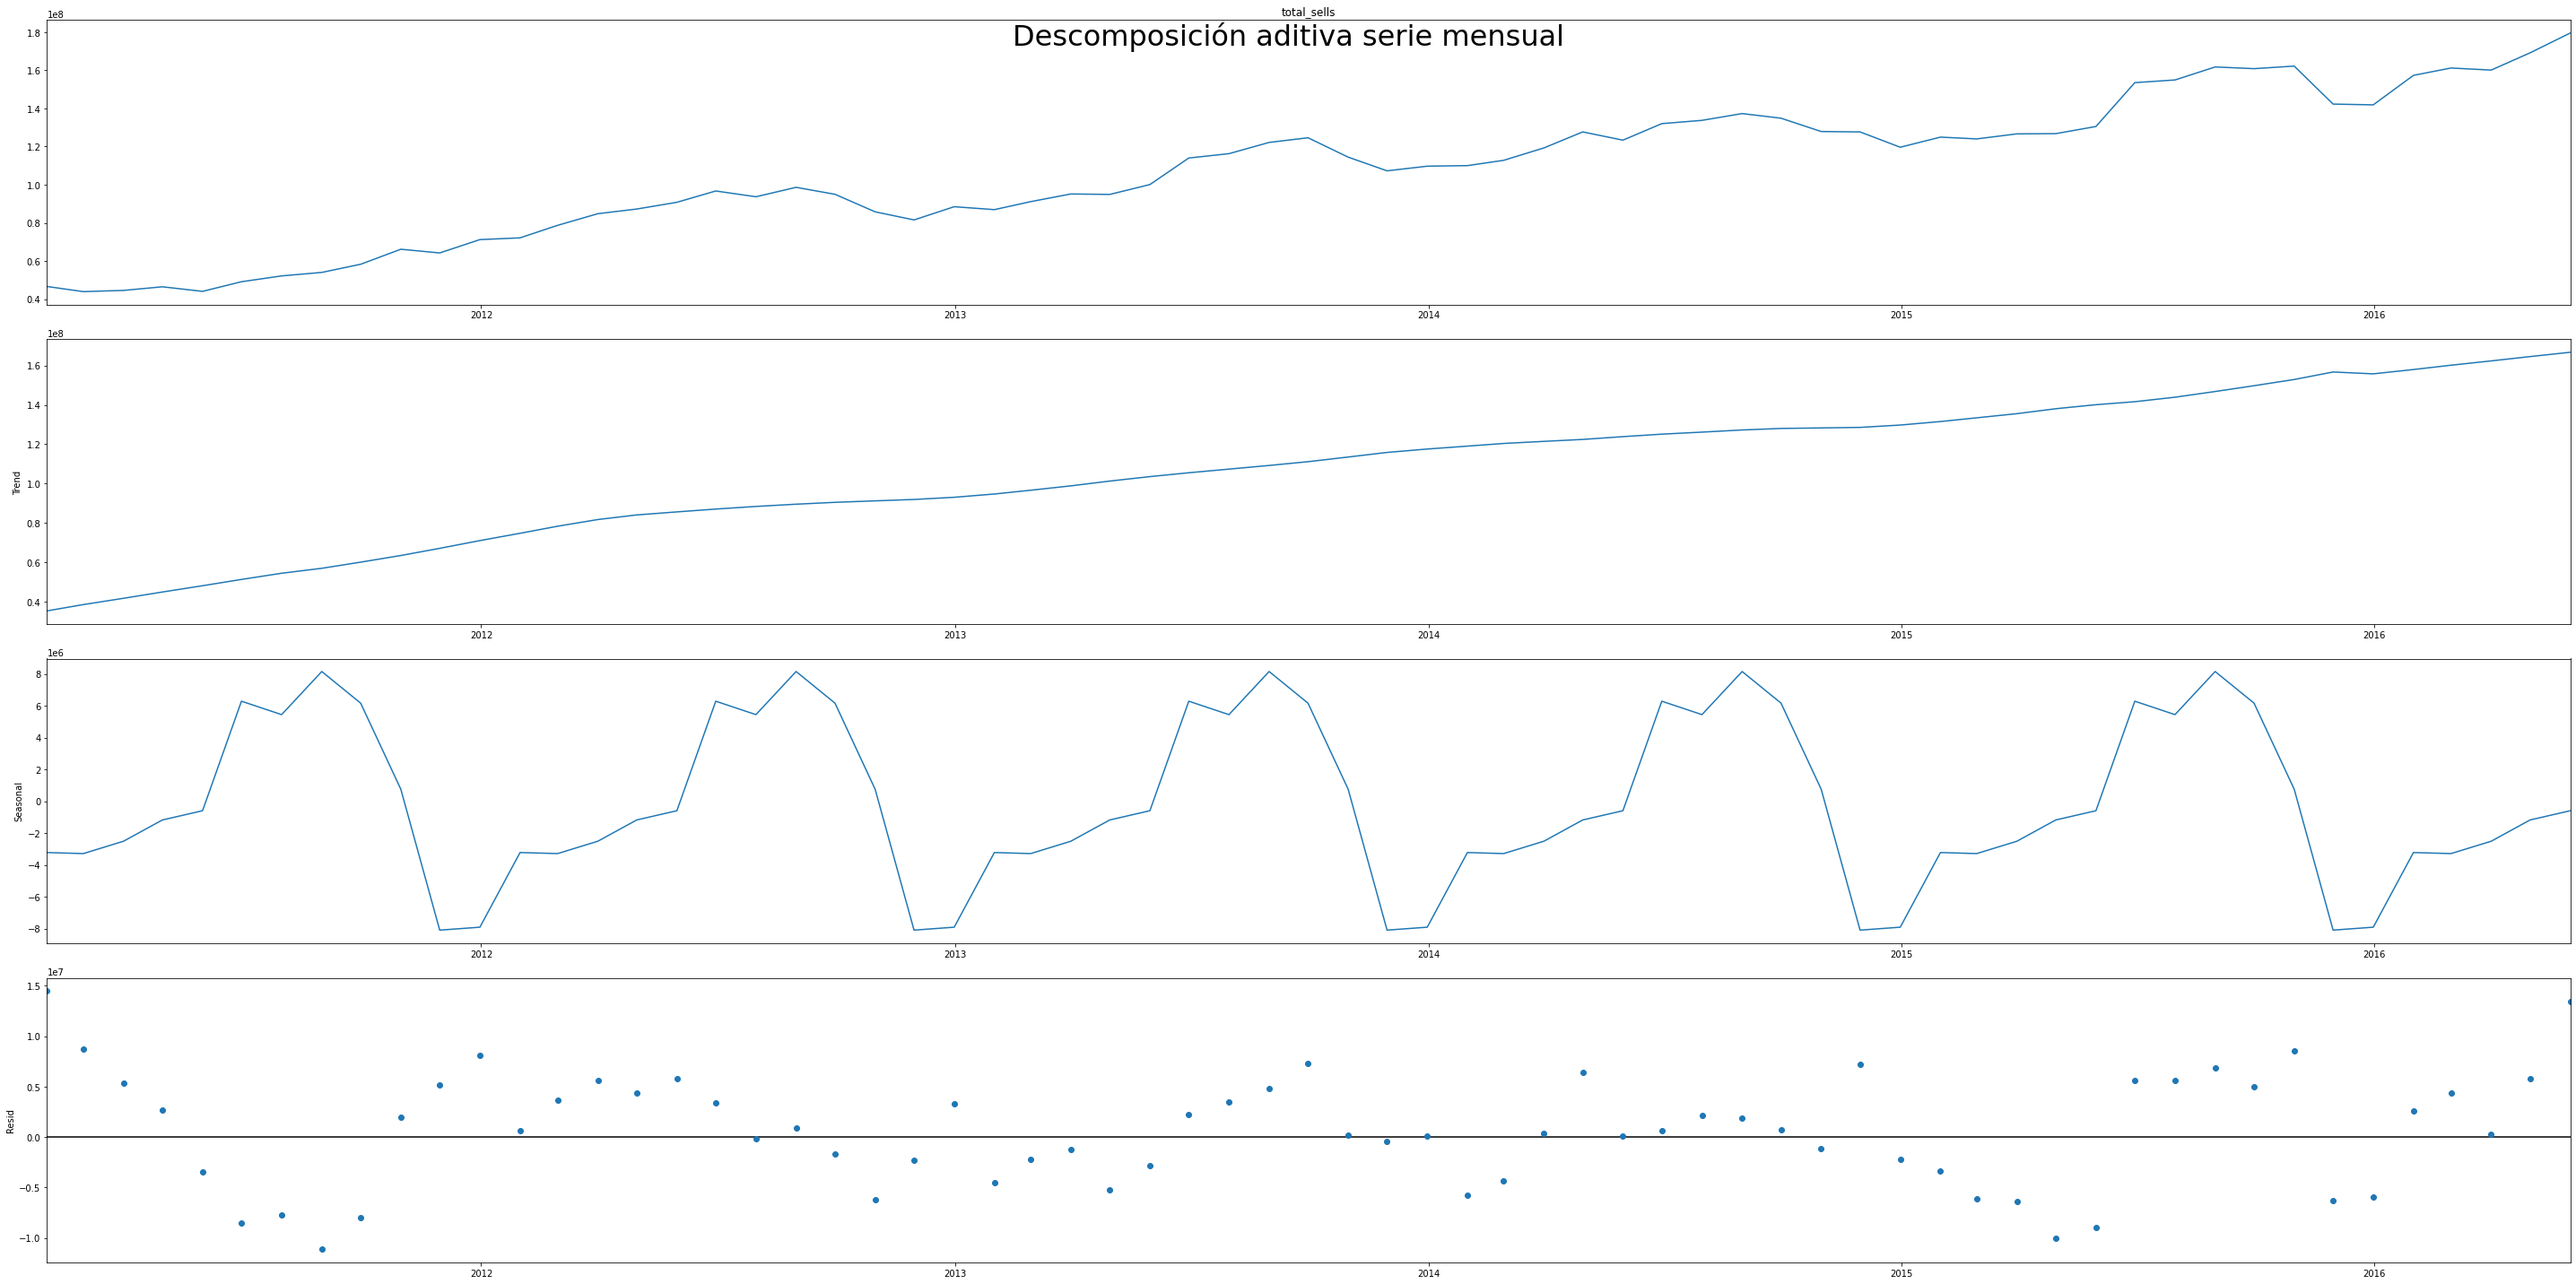

In [ ]:
# Descomposición multiplicativa
plt.figure(figsize=(40, 20))
result_mul = seasonal_decompose(Foods_m['total_sells'], model='multiplicative', extrapolate_trend='freq')

# Descomposición aditiva
result_add = seasonal_decompose(Foods_m['total_sells'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (40,20)})
result_mul.plot().suptitle('Descomposición multiplicativa serie mensual', fontsize=32)
result_add.plot().suptitle('Descomposición aditiva serie mensual', fontsize=32)
plt.show()

Al aplicar la descomposición agregada por mes se logra ver claramente una tendencia creciente que sugiere la necesidad de diferenciar la serie. Adicionalmente con la alta varianza identificada se propone la aplicación de transformación logaritmica para reducirla. 
Con respecto a la estacionalidad se observa una repetición en el patron tanto semanal, cómo mensual y anual, lo que indica un posible modelamiento SARIMA(p,d,q)X(P,D,Q)
Con respecto a los ersiiduales se observan patrones no lineales lo que permite pensar que existen variables exógenes que la serie por si misma no logra identificar. Se propone realizar test de normalidad. 


**Diagrama de caja distribución mensual (estacional) y anual (tendencia)**

In [ ]:
# Creación de las variables dia y año
Foods["dia"] = Foods.index.day
Foods["Mes"] = Foods.index.month
Foods["Año"] = Foods.index.year

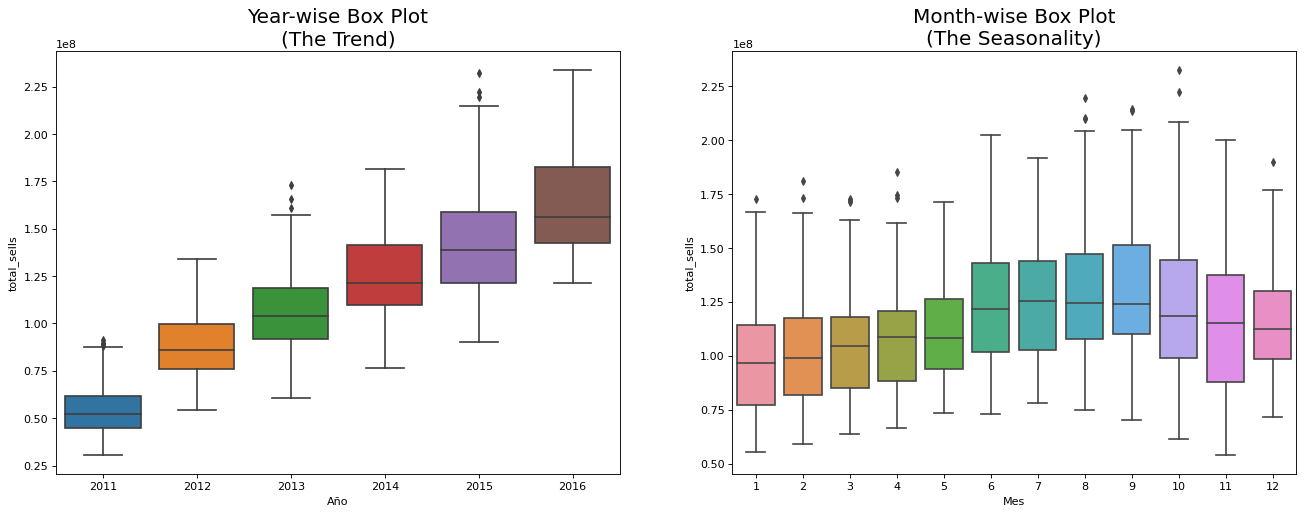

In [ ]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='Año', y='total_sells', data=Foods, ax=axes[0])
sns.boxplot(x='Mes', y='total_sells', data=Foods.loc[~Foods['Año'].isin([2011, 2016]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

#1.2. Transformaciones para garantizar la estacionariedad de la serie

Los modelos estadísticos clásicos para el modelamiento de series de tiempo requieren que estas cumplan las propiedades de estacionaridad, es decir, que tanto la media como la varianza sean constantes en el tiempo. 
Desde la gráfica inicial de la serie habíamos identificado que presenta tendencia creciente y que su varianza tiene comportamientos diferenciales en ciertos momentos. Por lo tanto, la serie no es estacionaria, luego debemos realizar transformaciones que la lleven a cumplir las propiedades y validar ese comportamiento mediante la prueba analítica de  Dickey-Fuller cómo se puede observar a continuación: 

**1.2.1. Para la estabilización de la varianza haremos uso de la transformación logarítmica**

In [ ]:
Foods["sells_log"] = Foods["total_sells"].apply(np.log)
Foods["date"]= Foods.index
Foods.head()

Unnamed: 0  total_sells  dia  Mes   Año  sells_log       date
date                                                                     
2011-01-29           0  52505705.07   29    1  2011  17.776432 2011-01-29
2011-01-30           3  51263366.34   30    1  2011  17.752487 2011-01-30
2011-01-31           6  36095398.08   31    1  2011  17.401676 2011-01-31
2011-02-01           9  40877622.48    1    2  2011  17.526093 2011-02-01
2011-02-02          12  37311746.46    2    2  2011  17.434819 2011-02-02

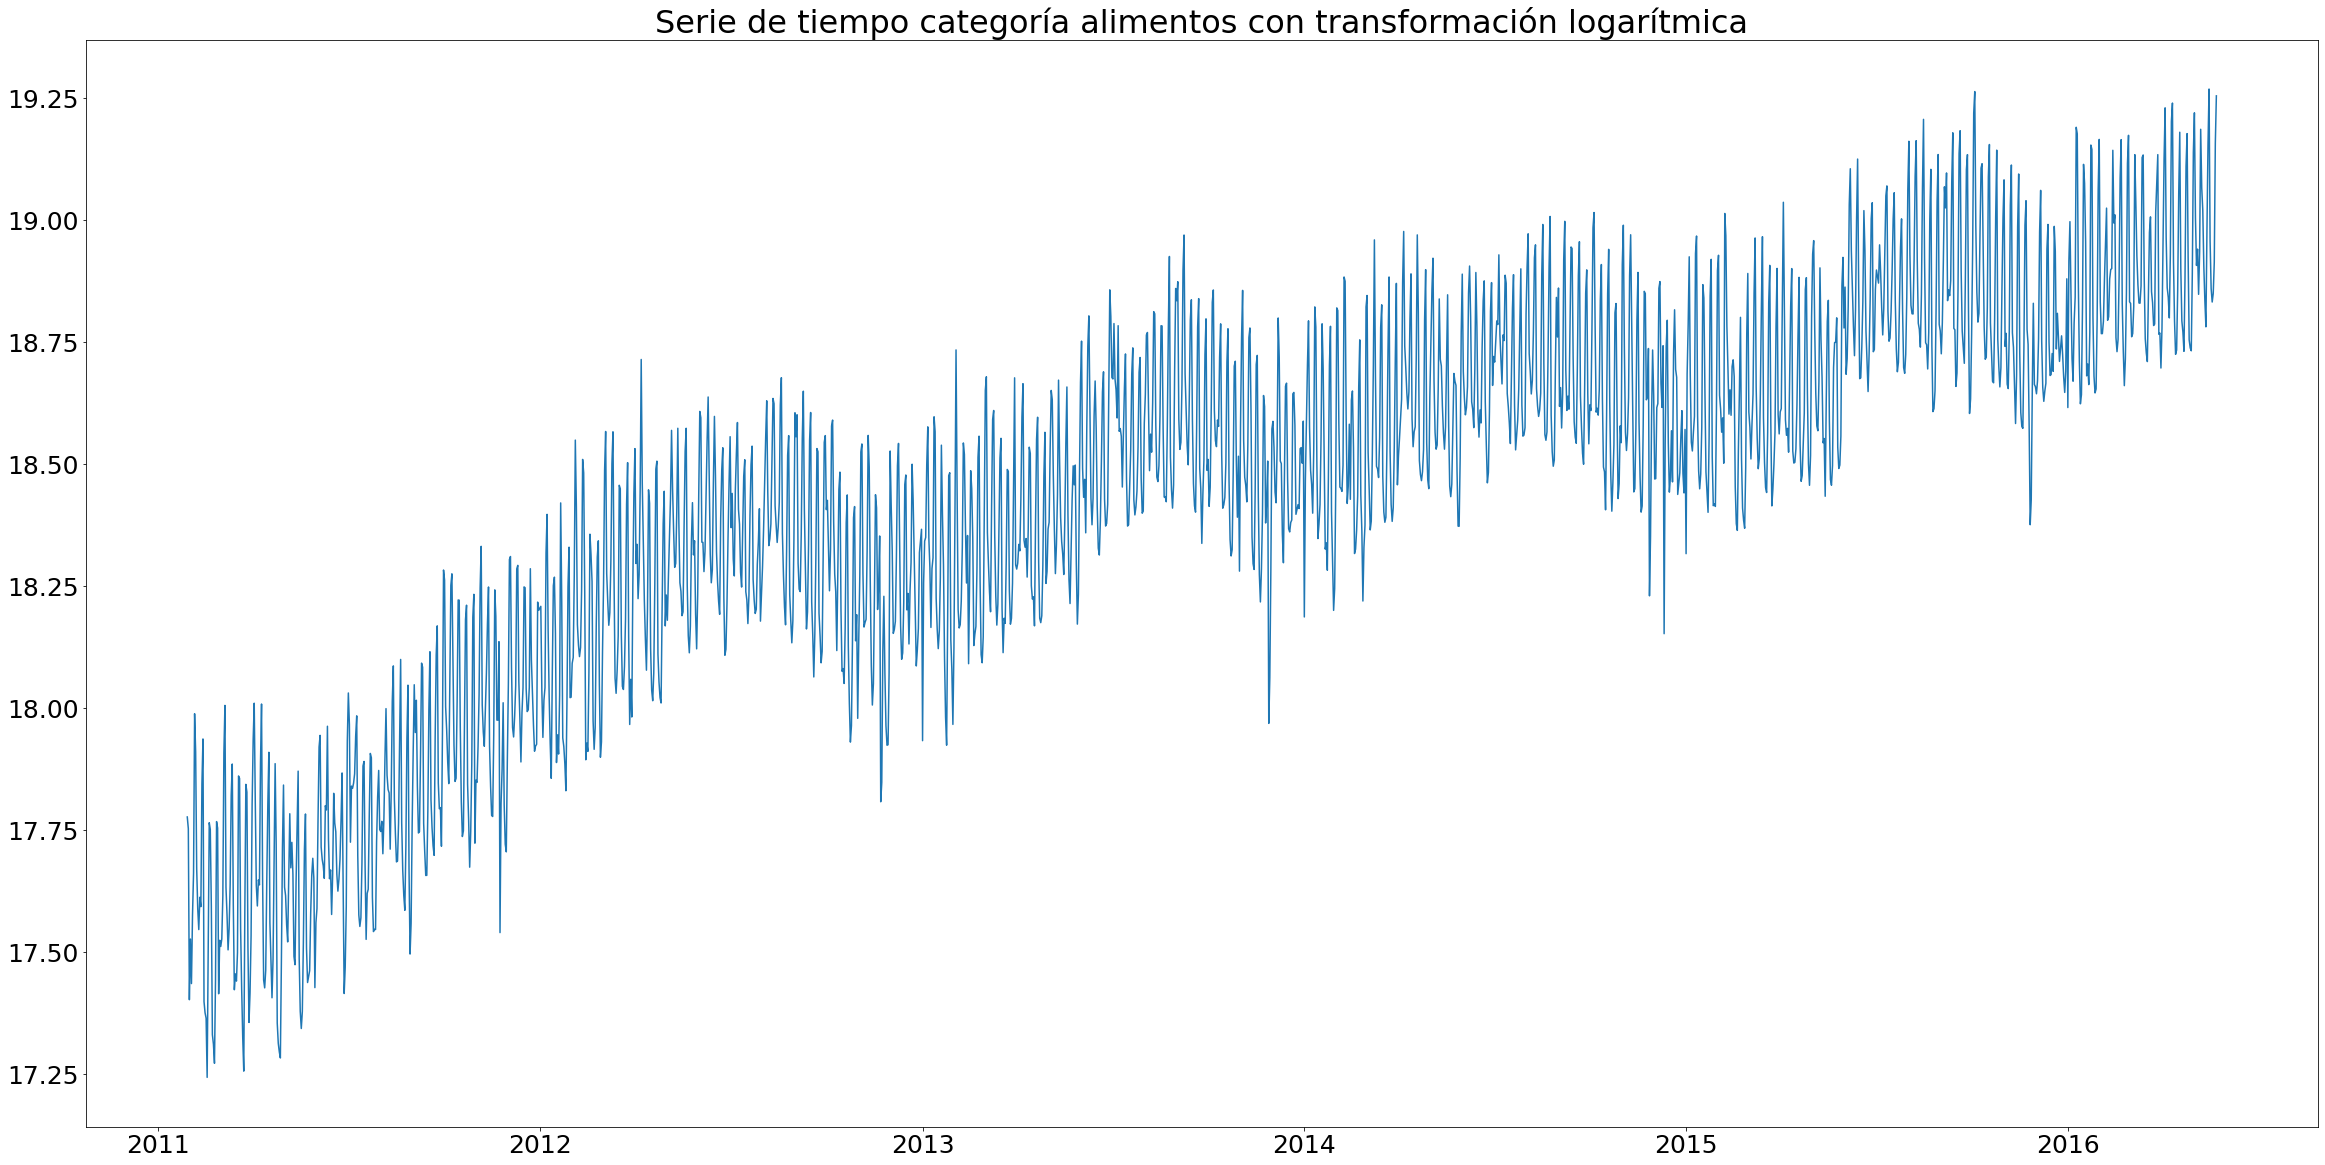

In [ ]:
plt.figure(figsize=(40, 20))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Serie de tiempo categoría alimentos con transformación logarítmica',fontsize=32)
plt.plot(Foods["date"],Foods['sells_log'])
plt.show()

**1.2.2. Para la estabilización en media aplicaremos diferenciación**

La diferenciaciación se define como la resta del valor actual con el valor anterior 

In [ ]:
# Estabilización del nivel con la diferenciacion
Foods["Dif_Log_foods"] = Foods["sells_log"].diff()
Foods.dropna(inplace = True, axis = "rows")
Foods.head()

Unnamed: 0  total_sells  dia  Mes   Año  sells_log       date  \
date                                                                        
2011-01-30           3  51263366.34   30    1  2011  17.752487 2011-01-30   
2011-01-31           6  36095398.08   31    1  2011  17.401676 2011-01-31   
2011-02-01           9  40877622.48    1    2  2011  17.526093 2011-02-01   
2011-02-02          12  37311746.46    2    2  2011  17.434819 2011-02-02   
2011-02-03          15  42915265.92    3    2  2011  17.574738 2011-02-03   

            Dif_Log_foods  
date                       
2011-01-30      -0.023945  
2011-01-31      -0.350811  
2011-02-01       0.124417  
2011-02-02      -0.091275  
2011-02-03       0.139919

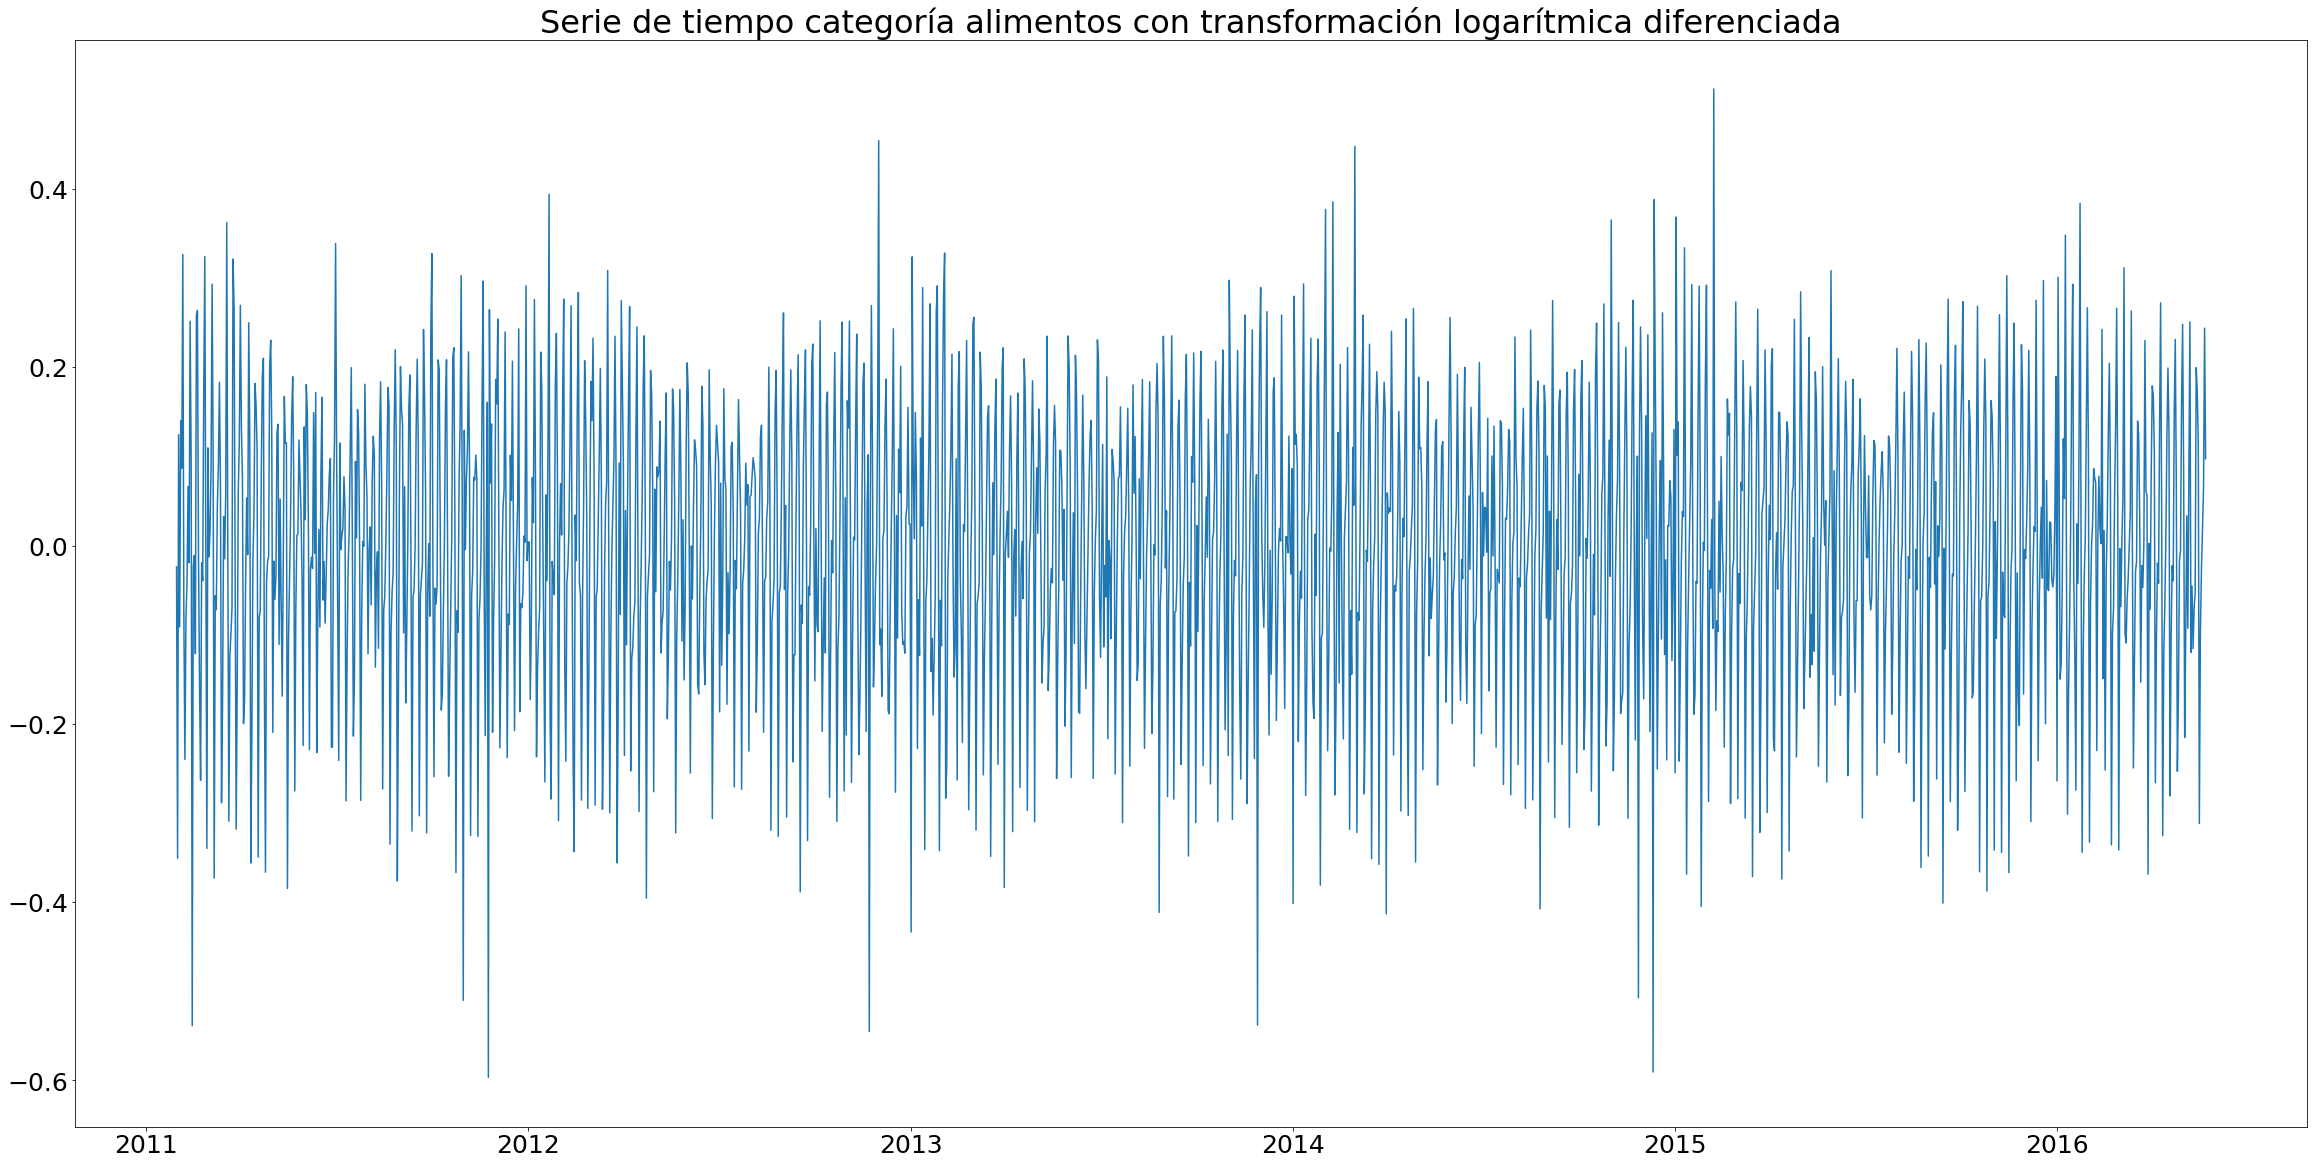

In [ ]:
plt.figure(figsize=(40, 20))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Serie de tiempo categoría alimentos con transformación logarítmica diferenciada',fontsize=32)
plt.plot(Foods['date'],Foods['Dif_Log_foods'])
plt.show()

# 1.3. Validación de estacionaridad de la serie de tiempo

Luego de las transformaciones anteriores se puede validar mediante las puerbas de raices unitarias la propiedad de estacionaridad de la serie. Para ello proponemos realizar la prueba de Dickey-Fuller. 
A modo de validación se realizará esta prueba en cada paso: serie original, serie con transformación logarítmica y serie logarítmica diferenciada. 

In [ ]:
from statsmodels.tsa.stattools import adfuller

**1.3.1. Test de Dick & Fuller serie original**

In [ ]:
test_results = adfuller(Foods["total_sells"])

print(f"ADF test statistic: {test_results[0]}")
print(f"p-value: {test_results[1]}")
print("Critical thresholds:")

for key, value in test_results[4].items():
   print(f"\t{key}: {value}")

ADF test statistic: -0.6052440187162351
p-value: 0.8697926852691151
Critical thresholds:
	1%: -3.433772946369569
	5%: -2.8630520356606137
	10%: -2.567574949489954


Dado que el valor p es superior a 0.05 la serie no es estacionaria

**1.3.2. Test de Dick & Fuller logaritmo de la serie**

In [ ]:
test_results = adfuller(Foods["sells_log"])

print(f"ADF test statistic: {test_results[0]}")
print(f"p-value: {test_results[1]}")
print("Critical thresholds:")

for key, value in test_results[4].items():
   print(f"\t{key}: {value}")

ADF test statistic: -2.0257697972352506
p-value: 0.2753894792820052
Critical thresholds:
	1%: -3.433772946369569
	5%: -2.8630520356606137
	10%: -2.567574949489954


Dado que el valor p es superior a 0.05 la serie no es estacionaria

**1.3.3. Test de Dick & Fuller serie con aplicación de logaritmo y diferenciada**

In [ ]:
test_results = adfuller(Foods["Dif_Log_foods"])

print(f"ADF test statistic: {test_results[0]}")
print(f"p-value: {test_results[1]}")
print("Critical thresholds:")

for key, value in test_results[4].items():
   print(f"\t{key}: {value}")

ADF test statistic: -21.342427888510855
p-value: 0.0
Critical thresholds:
	1%: -3.433772946369569
	5%: -2.8630520356606137
	10%: -2.567574949489954


Dado que el valor p es inferior a 0.05 la serie es estacionaria 

Otro de los elementos relevantes de análisis es la desestacionalización, es decir eliminar la relación entre ciclos o temporadas particulares. En este sentido, existen diferentes alternativas de solución como son: 1. Tomar una media móvil con la longitud como la ventana estacional, 2. Diferenciar estacionalmente la serie (restar el valor de la temporada anterior al valor actual) o 3. Dividir la serie por el índice estacional obtenido de la descomposición 

[]

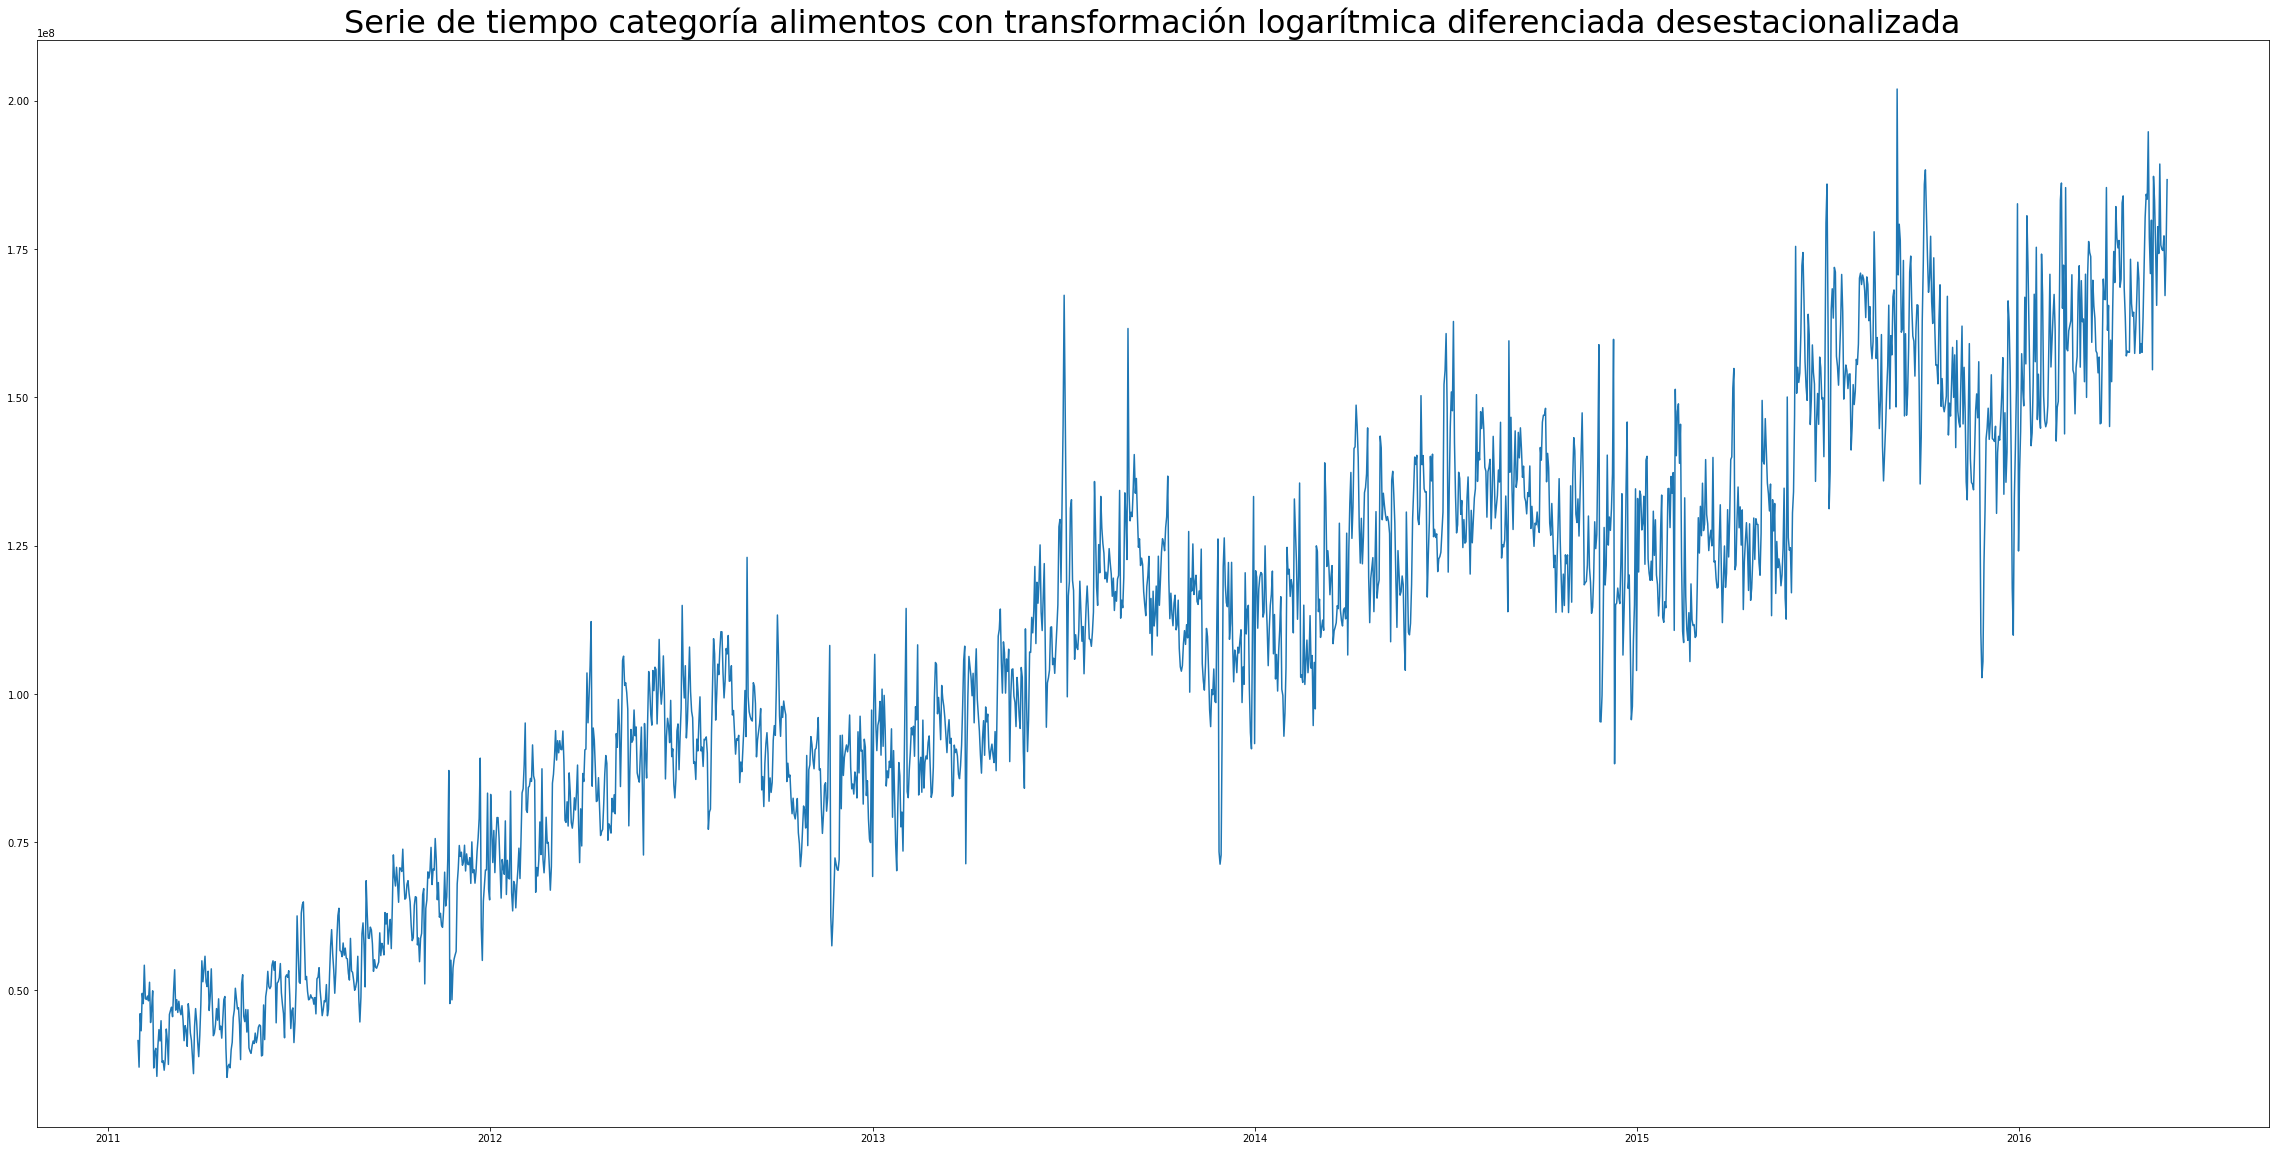

In [ ]:
# Restar el componente de la tendencia
plt.figure(figsize=(40, 20))

# descomposición de la serie 
result_mul = seasonal_decompose(Foods['total_sells'], model='multiplicative', extrapolate_trend='freq')

# Desestacionalidad 
deseasonalized = Foods.total_sells.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Serie de tiempo categoría alimentos con transformación logarítmica diferenciada desestacionalizada',fontsize=32)
plt.plot()

Si bien este procedimiento puede dar luces acerca de la estacionalidad de la serie de tiempo, la mejor forma de identificar esos patrones cíclicos es a través de los correlogramas. 

# 1.4. Análisis correlogramas

**Autocorrelación** definido como la correlación de la serie con sus propios rezagos. Si una serie está significativamente autocorrelacionada, significa que los valores anteriores de la serie pueden ser útiles para predecir el valor actual.

**Autocorrelación parcial** identifica la correlación pura de una serie y su rezago, excluyendo las contribuciones de correlación de los rezagos intermedios.

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

**Correlograma serie con aplicación del logaritmo y diferenciada**

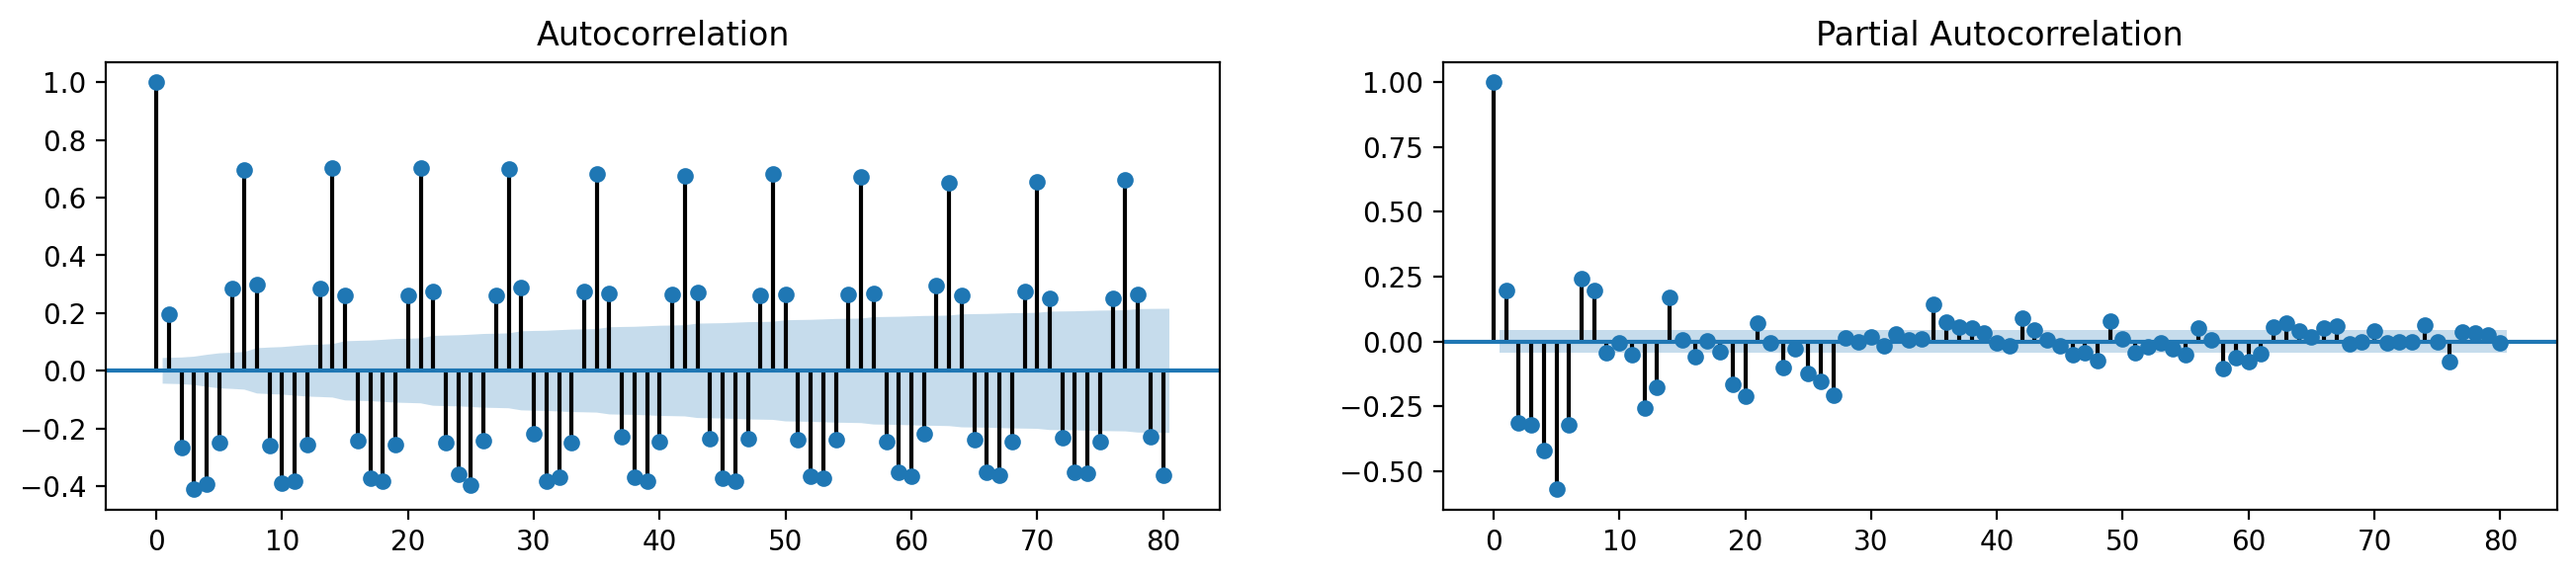

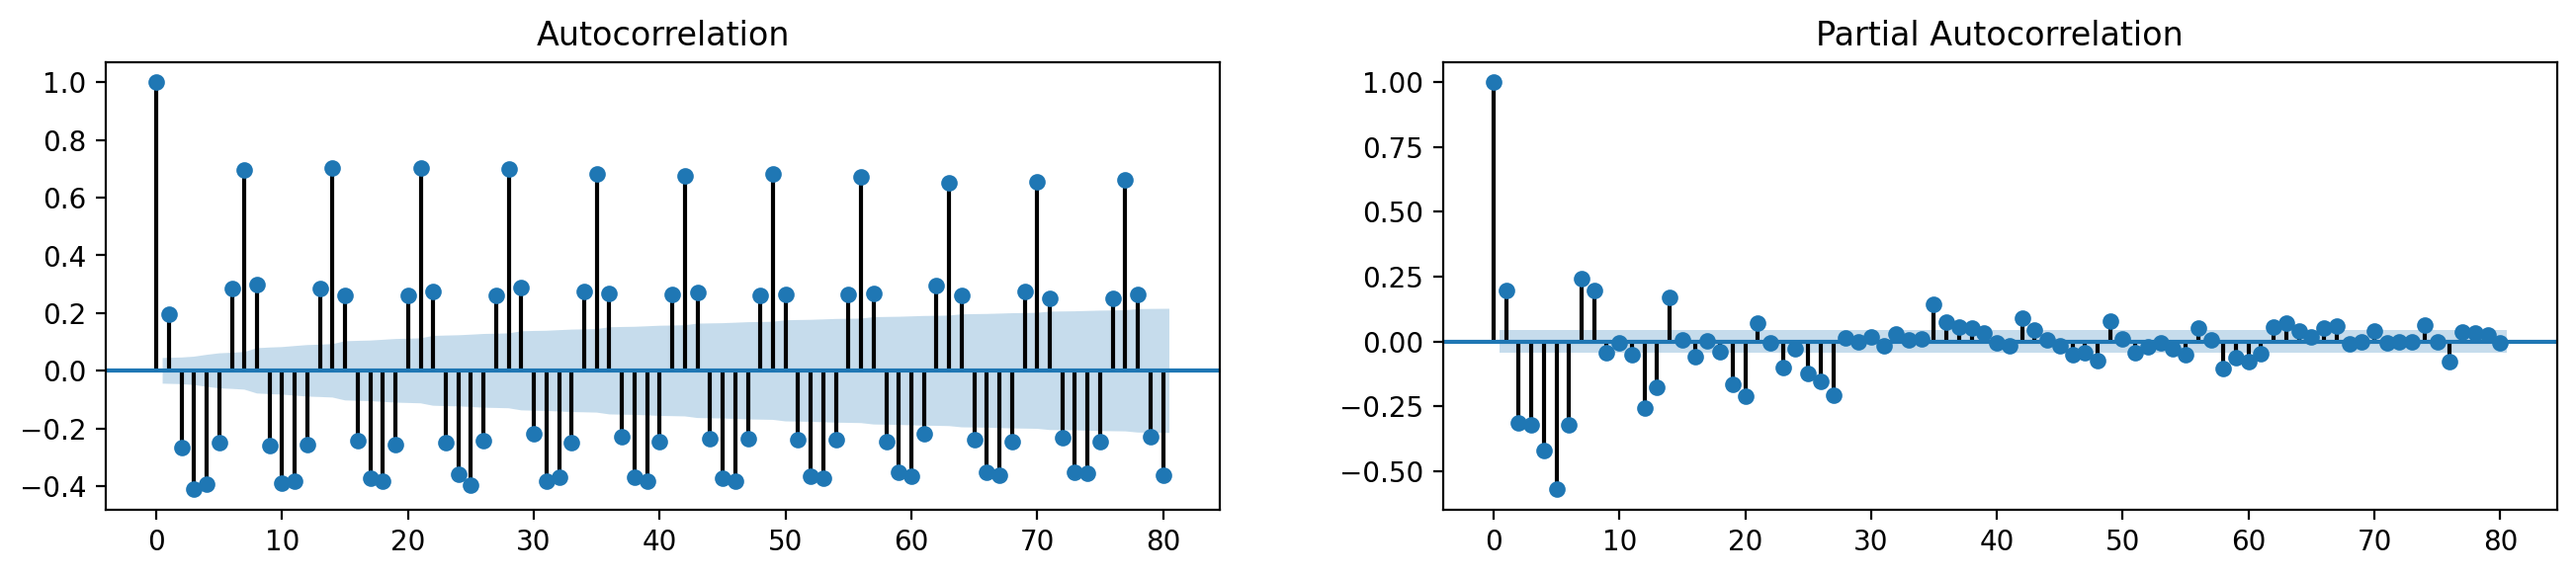

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 200)
plot_acf(Foods.Dif_Log_foods.tolist(), lags=80, ax=axes[0])
plot_pacf(Foods.Dif_Log_foods.tolist(), lags=80, ax=axes[1])

Considerando el resultado de los correlogramas correspondiente a la serie estacionaria, es decir con las transformaciones logaritmo y diferenciación (con la primera diferencia) se puede observar barras signiticativas tanto desde el componente autorregresivo como de medias móviles por lo que se espera que el modelo sea de tipo ARIMA. 

Adicionalmente, se observa de manera clara un comportamiento clíclico en el componente AR, por lo que se presume existe componente estacional en forma de ondas sinusoidales cada 7 rezagos. 

De acuerdo con los correlogramas, se propone el modelo ARIMA(5,1,4) o ARIMA(3,1,6)

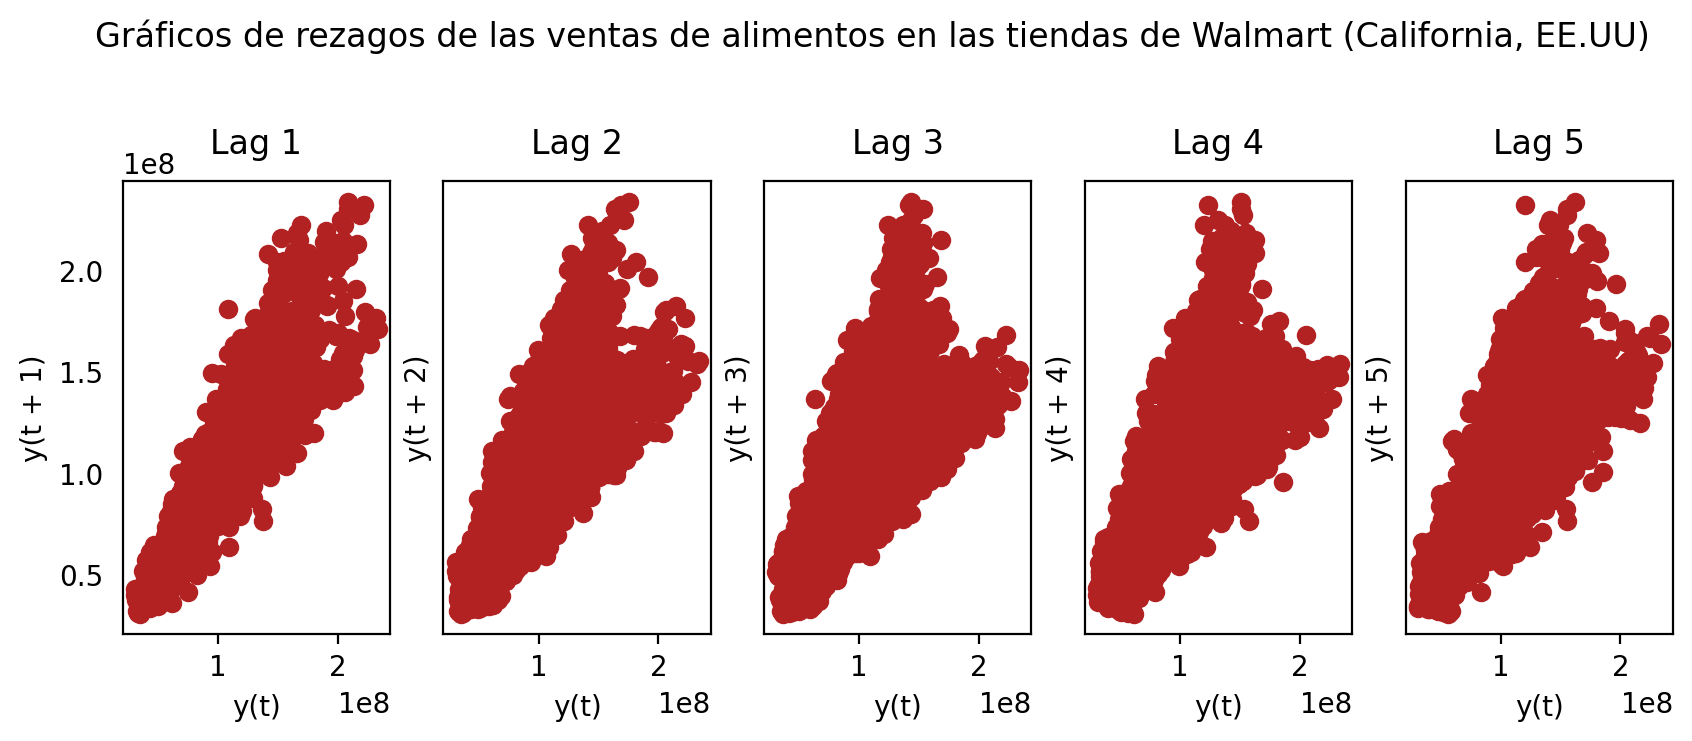

In [ ]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})


# Plot
fig, axes = plt.subplots(1, 5, figsize=(10,3), sharex=True, sharey=True, dpi=200)
for i, ax in enumerate(axes.flatten()[:5]):
    lag_plot(Foods.total_sells, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Gráficos de rezagos de las ventas de alimentos en las tiendas de Walmart (California, EE.UU)', y=1.15)    
  
plt.show()

Separación Train y Test

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# Entrenamiento del Modelo

Para el entrenamiento del modelo se porpone particionar los datos dejando 30 días para el testeo 

In [ ]:
train = Foods.iloc[:-30, :] 
test = Foods.iloc[-30: , :]

**Modelo S-ARIMA identificado gráficamente**

In [ ]:
modelo1= sm.tsa.statespace.SARIMAX(train['sells_log'], order =(5,1,4), seasonal_order = (1,0,0,52))

In [ ]:
resultados = modelo1.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
print(resultados.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           sells_log   No. Observations:                 1910
Model:             SARIMAX(5, 1, 4)x(1, 0, [], 52)   Log Likelihood                1973.185
Date:                             Fri, 02 Dec 2022   AIC                          -3924.369
Time:                                     05:37:26   BIC                          -3863.272
Sample:                                 01-30-2011   HQIC                         -3901.883
                                      - 04-22-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3912      0.022     17.474      0.000       0.347       0.435
ar.L2         -1.1085      

In [ ]:
resultados.resid

date
2011-01-30    17.752487
2011-01-31    -0.350811
2011-02-01     0.126279
2011-02-02    -0.165124
2011-02-03     0.071444
                ...    
2016-04-18    -0.012962
2016-04-19     0.016618
2016-04-20     0.010059
2016-04-21    -0.048023
2016-04-22     0.003866
Freq: D, Length: 1910, dtype: float64

Veamos a continuación la gráfica de los residuales

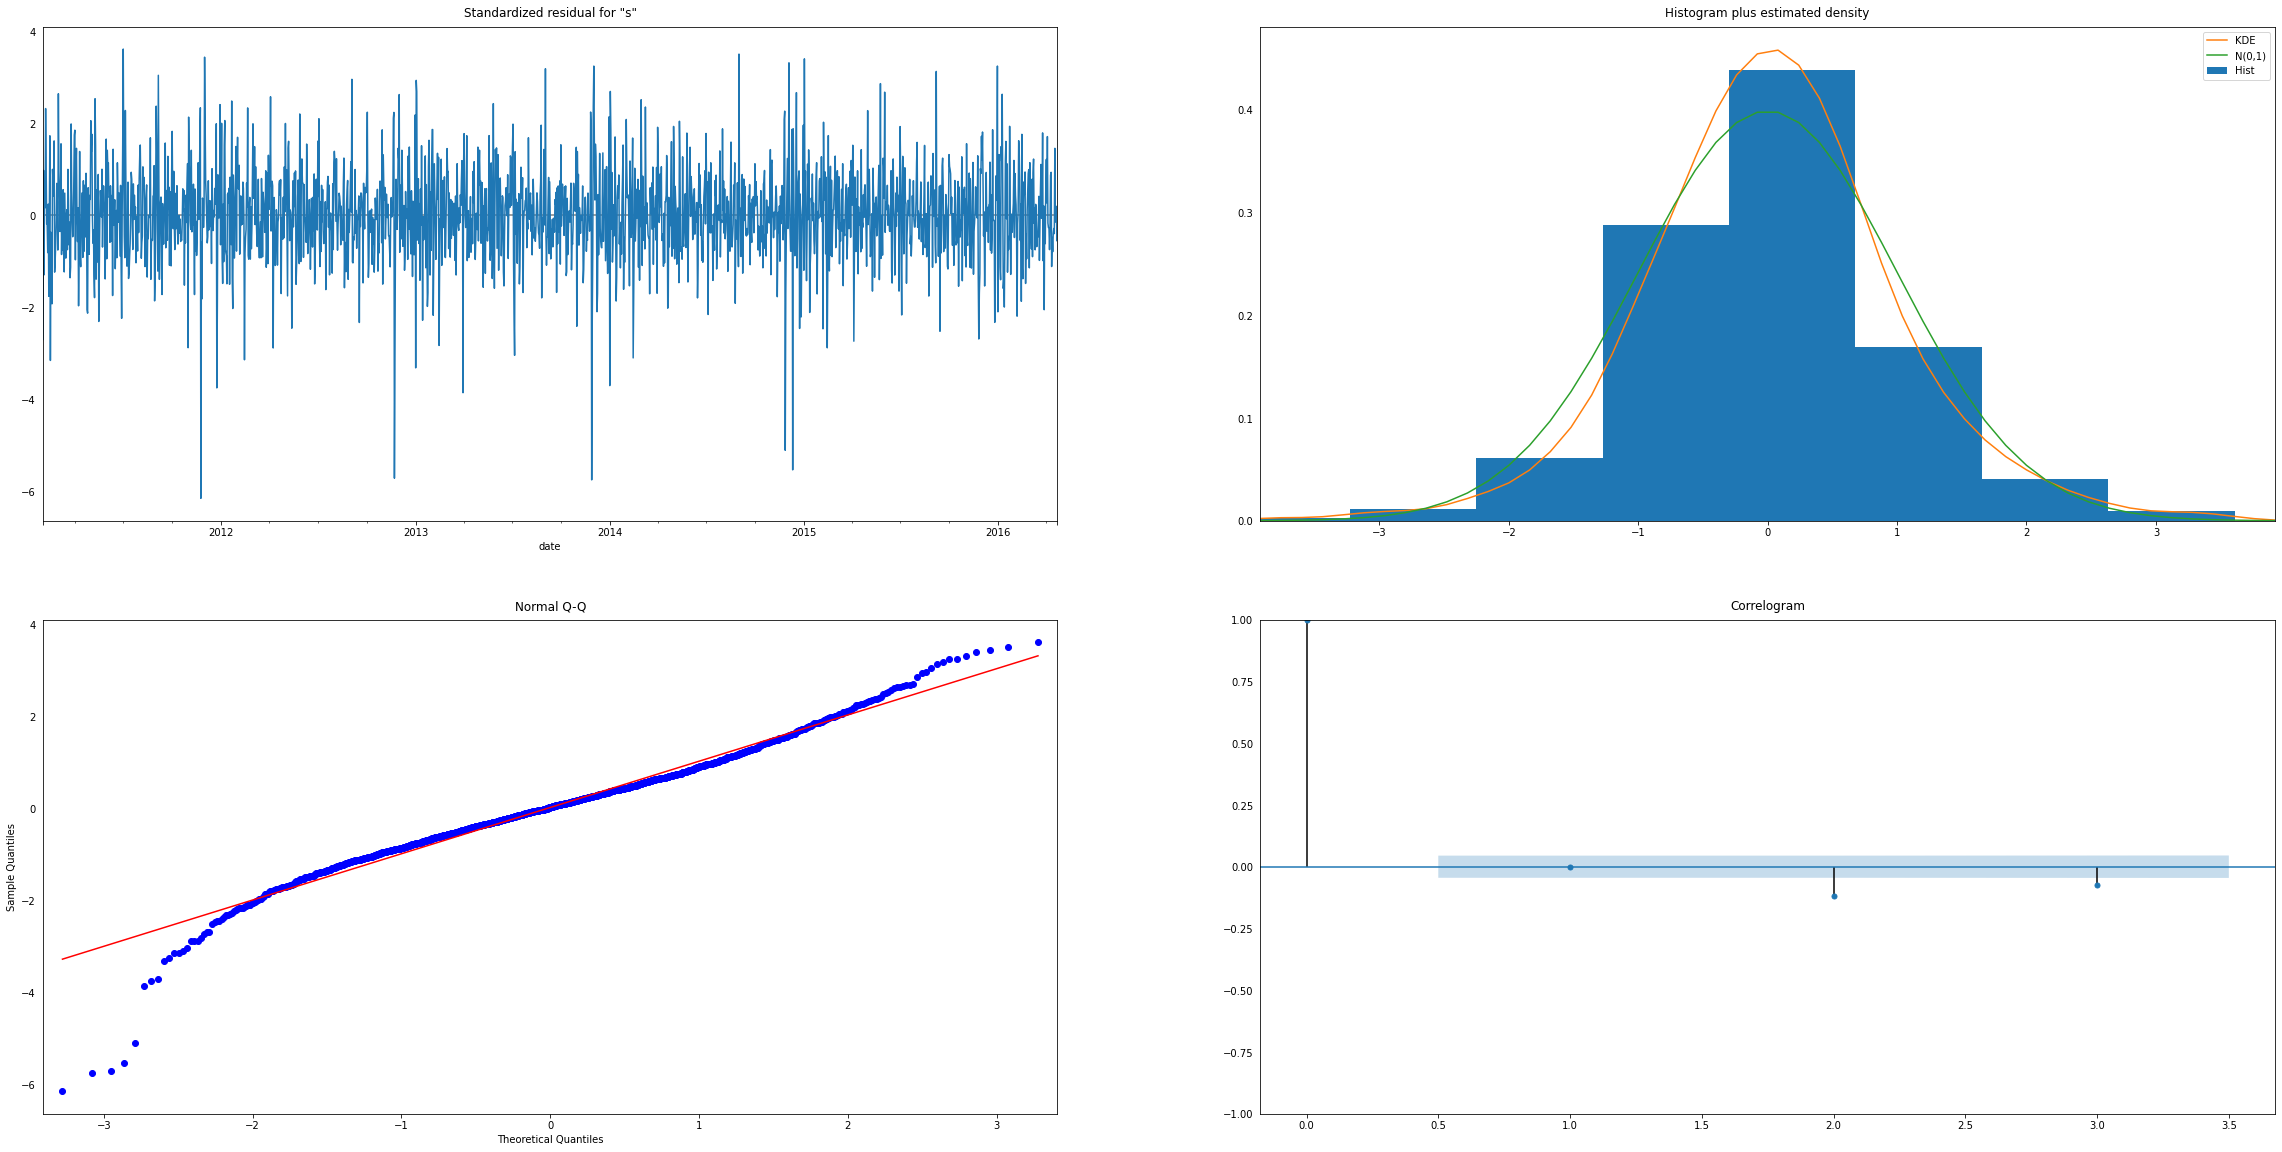

In [ ]:
resultados.plot_diagnostics(figsize = (40, 20), lags = 3);

De los gráficos anteriores se puede observar que: 

Arriba a la izquiera: los residuos del modelo parece que siguen un proceso de ruido blanco lo que indica que el modelo ha extraído de manera correcta la información de los datos.
Arriba a la derecha: vemos que la distribución de los residuos sigue una distribución próxima a la Normal (0, 1).
Abajo a la izquierda: El gráfico de cuantiles de la normal logra una línea recta aproximadaemtne normal. Sin embargo, en las colas se identifican algunos residuos no modelados correctamente, esto podría indicar que exiten algunas componentes exógenas a la serie que no logran ser capturadas por el modelo. 
Abajo a la derecha: vemos que la autocorrelación parcial entre los residuos y residuos - k, dan lugar a valores no significativos. 


In [ ]:
modelo2= sm.tsa.statespace.SARIMAX(train['sells_log'], order =(5,1,4), seasonal_order = (1,0,0,12))

In [ ]:
resultados2 = modelo2.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
print(resultados2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           sells_log   No. Observations:                 1910
Model:             SARIMAX(5, 1, 4)x(1, 0, [], 12)   Log Likelihood                1959.075
Date:                             Fri, 02 Dec 2022   AIC                          -3896.149
Time:                                     05:37:35   BIC                          -3835.052
Sample:                                 01-30-2011   HQIC                         -3873.663
                                      - 04-22-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4655      0.025     18.506      0.000       0.416       0.515
ar.L2         -1.1606      

In [ ]:
resultados2.resid

date
2011-01-30    17.752487
2011-01-31    -0.350811
2011-02-01     0.156476
2011-02-02    -0.168123
2011-02-03     0.040272
                ...    
2016-04-18    -0.027277
2016-04-19     0.029438
2016-04-20     0.017841
2016-04-21    -0.050962
2016-04-22    -0.004897
Freq: D, Length: 1910, dtype: float64

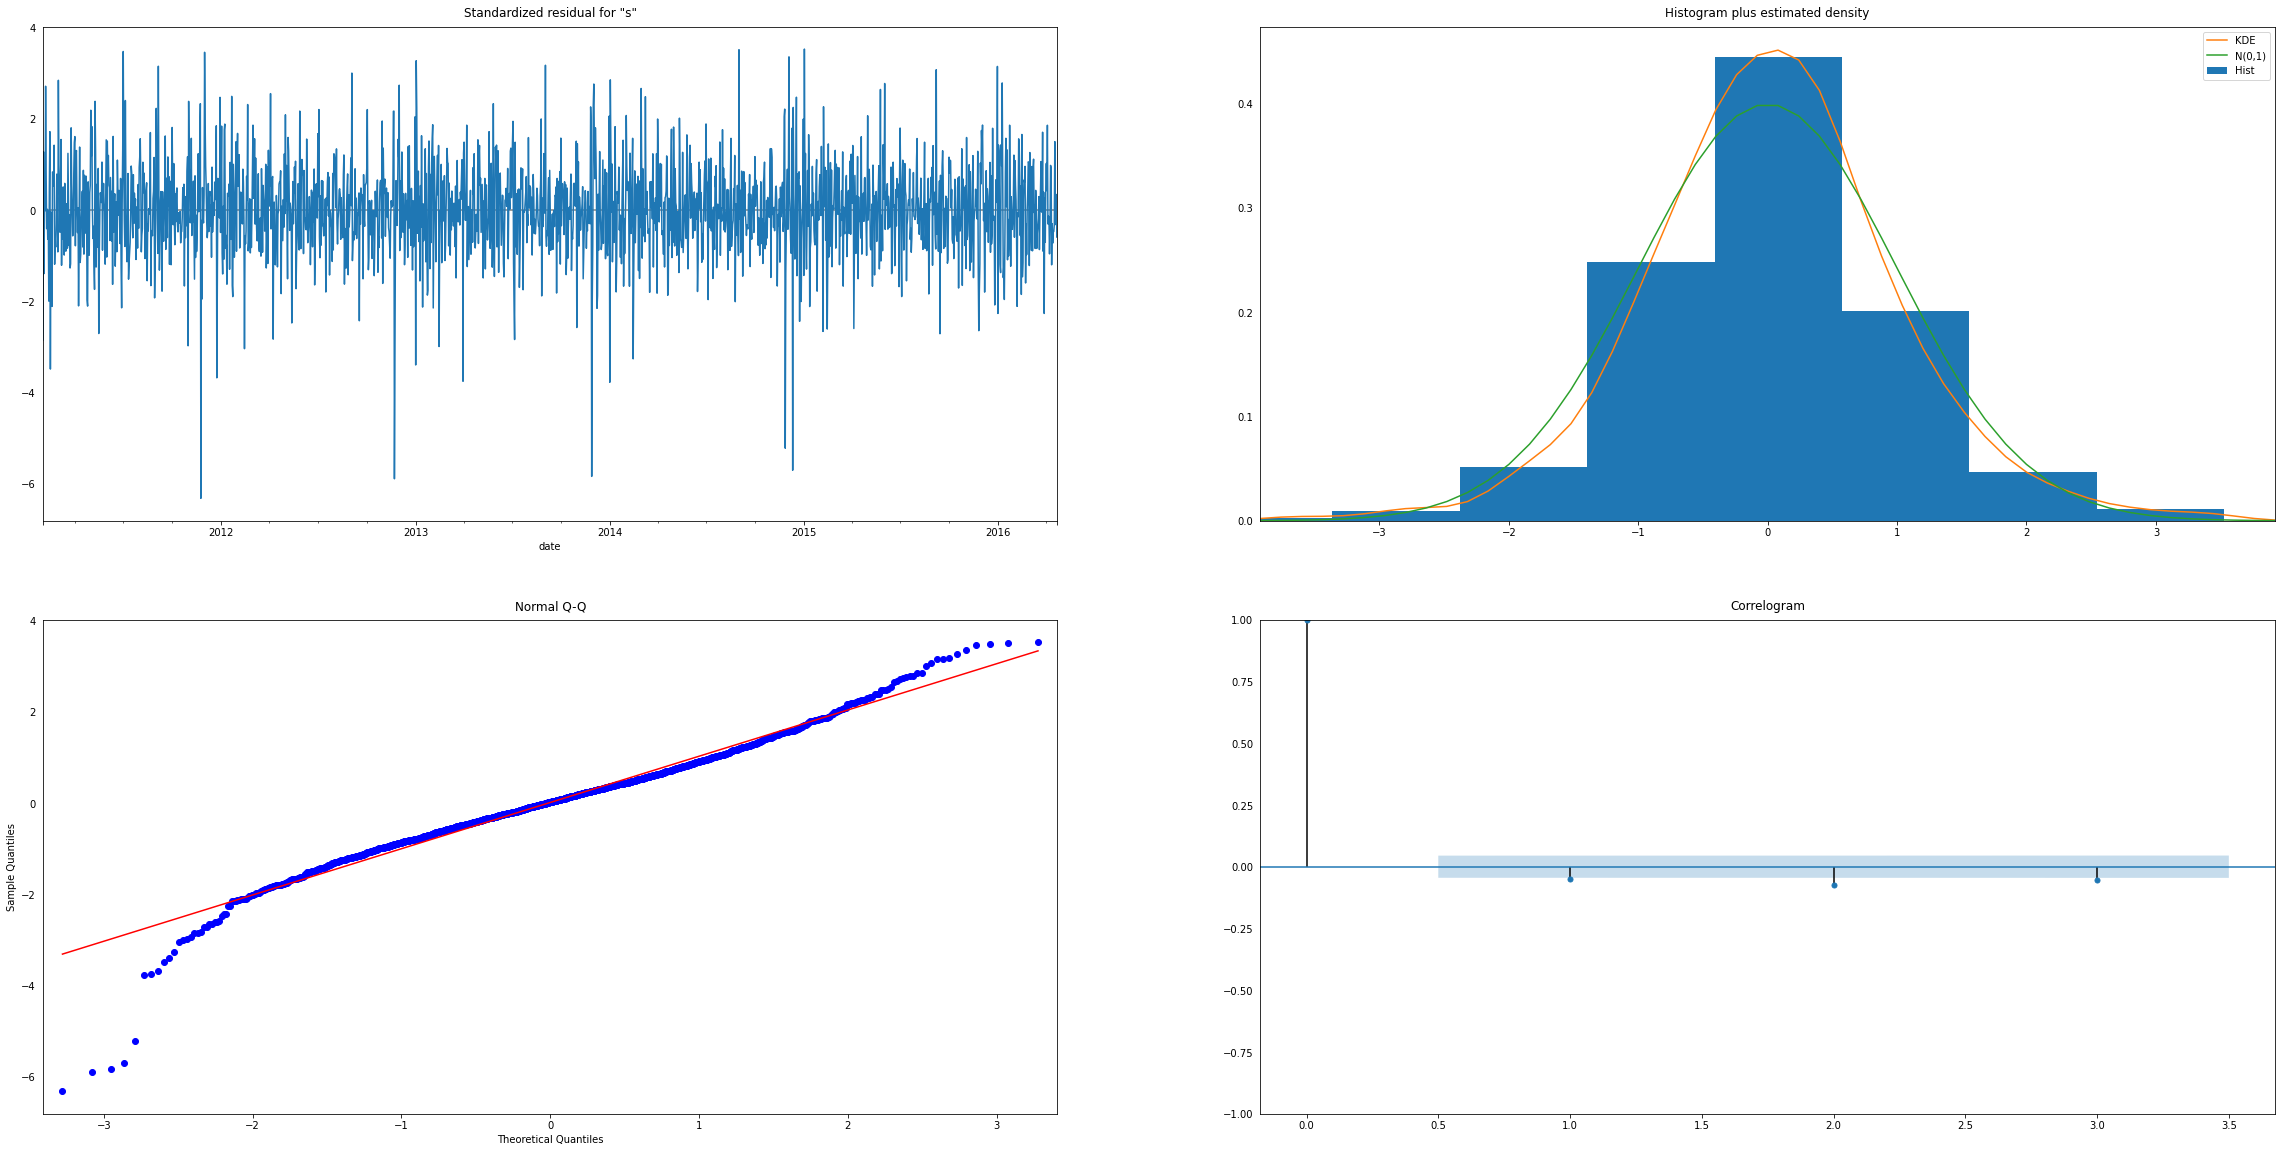

In [ ]:
resultados2.plot_diagnostics(figsize = (40, 20), lags = 3);

**Modelo S-ARIMA identificado con autoarima**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 30.1 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kats 0.2.0 requires statsmodels==0.12.2, but you have statsmodels 0.13.5 which is incompatible.


In [ ]:
import pmdarima as pm

In [ ]:
modelo3 = pm.auto_arima(train.sells_log,trace = True,suppress_warnings = True,seasonal = True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=13.00 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1631.248, Time=0.64 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1829.433, Time=3.00 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1959.631, Time=4.85 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1633.221, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-1752.830, Time=1.99 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-1968.344, Time=7.74 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-1861.374, Time=3.83 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=-2509.394, Time=12.78 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=-2508.546, Time=9.50 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=23.95 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=-2069.450, Time=14.94 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=-2201.020, Time=10.22 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=-2708.138, Time=18.89 sec
 ARIMA(1,1,

In [ ]:
modelo3.summary()

In [ ]:
modelo3= sm.tsa.statespace.SARIMAX(train['sells_log'], order =(1,1,1), seasonal_order = (1,0,2,12))

In [ ]:
resultados3 = modelo3.fit()

In [ ]:
print(resultados3.summary())

In [ ]:
resultados3.resid

In [ ]:
resultados3.plot_diagnostics(figsize = (40, 20), lags = 3);

**Predicción del Modelo Propuesto**

In [ ]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_modelo1 = resultados1.get_forecast(steps = len(test))

# Calcula el intervalo de confianza de la predicción.
pred_ic1 = pred_modelo1.conf_int()

In [ ]:
y_pred_1=np.exp(y_pred1)

In [ ]:
# Error Cuadrático Medio (MSE)
from sklearn import metrics
from math import sqrt

rmse1 = sqrt(metrics.mean_squared_error(y_true, y_pred1))
rmse1

In [ ]:
# Error absoluto Medio (MAE)
from sklearn.metrics import mean_absolute_error

y_true=y_true
y_pred1=y_pred1
MAE=mean_absolute_error(y_true, y_pred1)
MAE

In [ ]:
MAE_real=np.exp(MAE)
MAE_real

In [ ]:
ax = train['sells_log_t'].plot(label = 'Valores reales', figsize = (20, 15))

pred_modelo1.predicted_mean.plot(ax = ax, label = 'Predicción')

ax.fill_between(pred_ic1.index,
                pred_ic1.iloc[:, 0],
                pred_ic1.iloc[:, 1], color = 'k', alpha = .25)

ax.set_xlabel('Año')
ax.set_ylabel('Ventas de Hobbies')

plt.legend()
plt.show()